In [1]:
%%writefile cleaner.py
# %load cleaner.py
from config import Config
import re
import pandas as pd

class Cleaner:
    """
    A class used to clean and preprocess the data.
    ...
    
    Attributes
    ----------
    df : pd.DataFrame
        a pandas DataFrame containing the data to be cleaned
    table1 : pd.DataFrame
        a pandas DataFrame used for storing intermediate results
        
    Methods
    -------
    
    select_columns()
        Selects relevant columns from the DataFrame.
    get_alias()
    
        Extracts aliases from the notes.
    remove_newlines()
    
        Removes newline characters from the notes.
    remove_urls()
    
        Removes URLs from the notes.
    to_lowercase()
    
        Converts all text in the DataFrame to lowercase.
    ...
    """
        
    def __init__(self,df):
        self.df = df.copy()
        self.record_drops = []
        
    def select_columns(self):
        """
        Selects relevant columns from the DataFrame.
        Returns
        -------
        self
        """
        old_len = len(self.df)
        self.df = self.df[['BUSINESS_UNIT', 'HIT_ID','MATCH_TAG', 'MATCH_TEXT','MATCH_PATTERN_VALUE', 'MATCH_VALUE', 'L1_MAKER_LISTTYPE', 'MATCHABLE_DESCRIPTION',\
                           'OFFSET', 'L1_MAKER_ACTION', 'L1_MAKER_NOTE', 'L1_MAKER_INPUTTYPE', 'L2_MAKER_ACTION', 'L2_MAKER_NOTE']]
        self.df.columns = self.df.columns.str.lower()
        new_len = len(self.df)
        self.record_drops.append(('Select Columns', old_len - new_len))
        return self
    
    def filter_II_combinations(self):
        """
        Filters the dataframe to only keep rows where both l1_maker_inputtype 
        and l1_maker_listtype are 'Individual'.
        """
        self.df = self.df[
            (self.df['l1_maker_inputtype'] == 'Individual') & 
            (self.df['l1_maker_listtype'] == 'Individual')
        ]
        return self
    
    @staticmethod
    def extract_alias(text):
        cleaned=re.findall(r'[^#!@,~;.-]+', text)
        cleaned= ' '.join(cleaned)
        aka=re.findall(r'AKA (.*?)TYPE', cleaned)
        aka=' '.join(aka)
        return aka.strip()
    
    def get_alias(self):
        self.df["aka"] = self.df["matchable_description"].astype(str).apply(self.extract_alias)
        return self
    
    
    @staticmethod
    def preprocess_matchable_description(text):
        cleaned = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', text)
        cleaned = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr',
                         cleaned)
        cleaned = re.sub(r'£|\$', 'moneysymb', cleaned)
        cleaned = re.sub(
            r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
            'phonenumbr', cleaned)
        cleaned = re.sub(r'\d+(\.\d+)?', 'numbr', cleaned)
        cleaned = re.sub(r'[^\w\d\s]', ' ', cleaned)
        cleaned = re.sub(r'\s+', ' ', cleaned)
        cleaned = re.sub(r'^\s+|\s+?$', '', cleaned.lower())
        return cleaned.strip()
    
    @staticmethod
    def get_list_fullname(Matchable_Description):
        cleaned= re.sub(r'\bINPUT_DATE\b.+', '.', Matchable_Description)
        cleaned=re.findall(r'[^''#!@,]+', cleaned)
        cleaned= ' '.join(cleaned)
        hit=re.findall(r'(.*?)RISK_ID', cleaned)
        hit=' '.join(hit)
        hit=hit.replace("'","")
        list_name=re.sub(r'\s+',' ',hit).strip()
        return list_name
    
    def get_list_name(self):
        self.df["list_name"] = self.df["matchable_description"].astype(str).apply(self.get_list_fullname)
        return self
    
    def clean_key_columns(self):
        key_columns = ['match_tag', 'match_value', 'match_text', 'match_pattern_value', 'list_name']
    
        # Replace punctuation in key columns
        for col in key_columns:
            self.df[col] = self.df[col].str.replace(',', '', regex=True)
    
        return self  

    def remove_inconclusive_matches(self):
        self.df = self.df[self.df['l1_maker_action'] != 'Potential Inconclusive Match']
        new_len = len(self.df)
        self.record_drops.append(('Remove Inconclusive Matches', old_len - new_len))
        return self
    
    def clean_l1_maker_note(self):
        self.df = self.df[~self.df['l1_maker_note'].str.lower().str.contains('pvt|guidance', na=False)]
        return self
    
    def clean_l2_maker_note(self):
        self.df = self.df[~self.df['l2_maker_note'].str.lower().str.contains('external|google|https', na=False)]
        return self
    

    def remove_newlines(self):
        self.df["l1_maker_note"] = self.df["l1_maker_note"].str.replace("\n", " ", regex=True)
        return self

    def remove_urls(self):
        self.df["l1_maker_note"] = self.df["l1_maker_note"].str.replace(r"http\S+|www\S+", "", regex=True)
        return self

    def to_lowercase(self):
        self.df["l1_maker_note"] = self.df["l1_maker_note"].str.lower()
        return self

    def standardize_phrases(self):
        # Define a dictionary of phrases to standardize
        
        phrases_to_standardize = {
        "cannot exclude without additional investigation": "cannot exclude without further investigation",
        "wykluczam bazujac na caloksztalcie informacji": "cannot exclude without further investigation",
        "wykluczam hit bazurac na cakoksztaicie informacii": "cannot exclude without further investigation",
        "wykluczam hit bazujac na catoksztaicie informac]a dotyczy os": "cannot exclude without further investigation",
        "input name has additional name components that do not match those of the list entry (including aliases).":"input name has additional components not matching list entry",
        "taxonomy (e.g., icrm sanctions) specific guidance applies.": "taxonomy specific guidance applies",
        "dob mismatch input entry dob": "date of birth mismatch",
        "dotyczy imienia/nazwiska płatność do szkoły / przedszkola za dziecko; brak związku z listą sdn": "payment for school/preschool child not related to sdn list",
        "dotyczy imienia nazwiska platnosc do szkoly przedszkola za dziecko brak zwiazku z lista sdn": "payment for school/preschool child not related to sdn list",
        "input is another known input type provided in a known unstructured format (free form field) that clearly indicates it i not the same type of information as the list entry": "input is a different type of information than list entry",
        "input is solely a single name component and list entry is multi name component": "input is a single name component and list entry is multi name component",
        "input name has additional name components that do not match those of the list entry (including aliases)": "input name has additional components not matching list entry",
        "wykluczam hit bazujac na caloksztalcie informacji": "cannot exclude without further information",
        "wykluczam hit bazujac na catoksztaicie informac]a dotyczy os": "cannot exclude based on the totality of information",
        'false match: clarification on file': 'false match',
        'transaction processed as it meets all criteria of policy waiver': 'transaction processed under policy waiver',
        'gender mismatch': 'gender does not match',
        'dob mismatch input entry': 'date of birth mismatch',
        }
        


        # Apply the standardizations
        for old_phrase, new_phrase in phrases_to_standardize.items():
            self.df["l1_maker_note"] = self.df["l1_maker_note"].astype(str).str.replace(old_phrase, new_phrase, regex=True)

        return self
    
    def remove_examples(self):
        self.df["l1_maker_note"] = self.df["l1_maker_note"].astype(str).str.replace(r"ex: .*", "", regex=True)
        return self

    def remove_rows_with_keywords(self):
        for keyword in Config.KEYWORDS:
            old_len = len(self.df)
            self.df = self.df[~self.df["l1_maker_note"].astype(str).str.contains(keyword)]
            new_len = len(self.df)
            self.record_drops.append((f'Remove Rows with Keyword: {keyword}', old_len - new_len))
        return self


    def standardize_potential_match_notes(self):
        self.df.loc[self.df["l1_maker_note"].str.contains("potential match", case=False, na=False), "l1_maker_note"] = "potential match"
        return self

    def remove_common_phrases(self, common_phrases):
        for phrase in common_phrases:
            self.df["l1_maker_note"] = self.df["l1_maker_note"].astype(str).str.replace(phrase, "", regex=True)
        return self

    def split_notes(self, separator="."):
        self.df["l1_maker_note"] = self.df["l1_maker_note"].astype(str).str.split(separator).str[0]
        return self

    def apply_guidelines(self):
        self.df["guideline_action"], self.df["guideline_reason"] = zip(*self.df.apply(lambda row: self.get_guidelines(row["l1_maker_inputtype"], row["l1_maker_listtype"]), axis=1))
        self.df.loc[self.df['guideline_action'].isna(), 'guideline_action'] = self.df.loc[self.df['guideline_action'].isna(), 'l1_maker_action']
        self.df.loc[self.df['guideline_reason'].isna(), 'guideline_reason'] = self.df.loc[self.df['guideline_reason'].isna(), 'l1_maker_note']
        return self

    @staticmethod
    def get_guidelines(input_type, list_type):
        cross_match_types = [
            ("Individual", "Entity"),
            ("Individual", "Vessel/Aircraft"),
            ("Entity", "Vessel/Aircraft"),
            ("Place/Location", "Individual"),
            ("Place/Location", "Entity"),
            ("Place/Location", "Vessel/Aircraft"),
            ("Vessel/Aircraft", "Individual"),
        ]
        
        out_of_scope_types = [("Other Input Type", "Individual")]

        if (input_type, list_type) in cross_match_types:
            return "False Match", "Cross Match"
        elif (input_type, list_type) in out_of_scope_types:
            return "Out of Scope", "Out of Scope"
        else:
            return None, None

    def is_english(self, text):
        try:
            str(text).encode(encoding='utf-8').decode('ascii')
        except UnicodeDecodeError:
            return False
        else:
            return True

    def detect_language(self):
        self.df["note_in_english"] = self.df["l1_maker_note"].apply(self.is_english)
        return self

    def preprocess_polish_notes(self):
        self.df["guideline_reason"] = self.df["guideline_reason"].apply(self.preprocess_note)
        return self
    
    @staticmethod
    def isEnglish(s):
        try:
            str(s).encode(encoding='utf-8').decode('ascii')
        except UnicodeDecodeError:
            return False
        else:
            return True


    @staticmethod
    def preprocess_note(note):
        if not Cleaner.isEnglish(note):
            # Remove punctuation
            note = re.sub(r'[^\w\s]', ' ', note)
            # Convert to lowercase
            note = note.lower()
            # Remove extra spaces
            note = re.sub(r'\s+', ' ', note).strip()
            note = re.sub(r'\s+', ' ', note).rstrip()

        return note
    
    def translate_notes(self):
        self.df["guideline_reason"] = self.df["guideline_reason"].apply(self.translate_polish_notes)
        return self

    @staticmethod
    def translate_polish_notes(note):
        if Cleaner.isEnglish(note):
            return note
        else:
            for polish_phrase, english_translation in Config.POLISH_TO_ENGLISH.items():
                note = note.replace(polish_phrase, english_translation)
            return note   


    def unify_string_formats(self):
        # Define a list of regular expressions to find and replace
        regex_replacements = [
            (r'dob mismatch input entry dob \d{2} \d{2} \d{2} star case id .*', 'date of birth mismatch'),
            (r'Input name and list entry dates of birth do not match dob: .*', 'date of birth mismatch'),
            (r'transaction processed as it meets all criteria of policy waiver id #\d*', 'transaction processed as it meets all criteria of policy waiver'),
            (r'input name and list entry \[.*\] do not match', 'input name and list entry do not match'),
            (r'input name and list entry dates of birth do not match.*', 'input name and list entry dates of birth do not match'),
            (r'input and list entry are both financial institutions and both the names of the financial institutions and first 4 charac ters of the swift bank identifier code \(bic\) do not match.*',  'input and list entry are both financial institutions and names and swift bic do not match'),
            (r'na podstawie danych z przelewu wykluczam hit, .*', 'exclude hit'),
            (r'input name has additional name components that do not match those of the list entry.*', 'input name has additional components not matching list entry'),
            (r'na podstawie danych z przelewu wykluczam hit .*', 'exclude hit'),
            (r'input name has additional name components that do not match those of the list entry.*', 'input name has additional components not matching list entry'),
            (r'dob mismatch input entry.*', 'date of birth mismatch'),
            (r'false match:.*', 'false match'),
            (r'components that are matching are different and not possible variations.*', 'matching components are different and not possible variations'),
            (r'dane wejsciowe zawieraja jeden element.*', 'contains one element'),
            (r'do weryfikacji', 'to verification'),
            (r'dotyczy platnosc.*brak zwiazku z lista sdn', 'pertains to child school payment'),
            (r'dotyczy imienia/nazwiska platnos.*brak zwiazku z lista sdn', 'pertains to name, no connection to SDN list'),
            (r'dotyczy płatności za dziecko*',  'pertains to child school payment'),
            (r'input is another known input type.*', 'input is another known input type'),
            (r'input name and list entry.*do not match', 'input name and list entry do not match'),
            (r'input name has additional components not matching list entry', 'input name has additional components not matching list entry'),
            (r'na podstawie danych wejsciowych wykluczam hit.*', 'exclude hit'),
            (r'nazmisko powtórzone w polu nadawcy i w detalach platnosci',  'surname repeated in the sender field and in the payment details'),
            (r'wykluczam bazujac na caloksztalcie informacji.*', 'exclude hit'),
            (r'wykluczam hit dopasowane komponenty nie wykazuja.*', 'exclude hit'),
            (r'laczenie wyrazów', 'combining words'),
            ('łączenie wyrazów', 'combining words'),
            (r'dane wejściowe zawierają jeden element, wówczas dopasowanie należy uznać za fałszywe', 'contains one element'),
            (r'contains one element*', 'contains one element'),
            (r'dob mismatch.*', 'date of birth mismatch'),
            (r'dane wejsciowe zawieraja jeden element.*', 'contains one element'),
            (r'dotyczy płatność.*','pertains to child school payment'),
            (r'do wer', 'to verify'),
            (r'wykluczam hit bazując na całokształcie.*','exclude hit'),
            (r'wykluczam bazując na całokształcie .*', 'exclude hit'),
            (r'dotyczy płatność do szkoły.*', 'pertains to child school payment'),
            (r'payment to child.*', 'pertains to child school payment'),
            (r'dotyczy.*', 'pertains to child school payment'),
            (r'payment for school/preschool child not related to sdn list', 'pertains to child school payment'),
            (r'brak możliwości wykluczenia bez przeprowadzenia dodatkowej inwestygacji','no foreclosure without additional investment'),
            (r'contains one element.*','contains one element'),
            (r'wykluczam hit.*', 'exclude hit'),
            (r'female vs','gender does not match'),
            (r'nazwisko powtórzone w polu nadawcy i w detalach płatności', 'name repeated in sender and payment details'),
            (r'klie.*', 'client bhw'),
            (r'iclient bhw', 'client bhw'),
            (r'na podstawie danych wejściowych exclude hit','exclude hit'),
            (r'skrot.*','pertains to child school payment'),
            (r'uck skrót odnosi się do nazwy nadawcy uniwersyteckie centrum kliniczne nie ma związku z podmiotem z listy sdn', 'abbreviations do not match'),
            (r'uck.*', 'abbreviations do not match'),
            (r'zgoda departamentu zgodności', 'compliance approval'),
            (r'hit jest zawarty w innym wyrazie nie ma powiązania z listą sdn','hit is contained in another word'),
            (r'na   exclude hit', 'exculde hit'),
            (r'mozna wykluczyć hit inne nazwy podmiotow i lokalizacje debtor name.*', 'no relation between entities'),
            (r'bazując na stronach i detalach transakcj.*','based on transaction details and similar transactions'),
            (r'(na podstawie danych w zleceniu inne nazwy firm inne formy działalności.*)','other company names from other forms have no relation'),
            (r'kleint bhw','client bhw'),
            ('.input and list entry are both financial institutions.*','input and list entry are both financial institutions and both the names of the financial institutions and first 4 characters of the swift bank identifier code (bic) do not match' ),
            (r'uniwersytet adama mickiewicza.*','different full names and locations'),
            (r'components that are matching are considered common references.*', 'components that are matching are considered common references and the input contains additional material name components that are not a reference to: place/location, corporate or legal identifiers'),
            (r'input and list entry are both financial institutions and both the names of the financial institutions and first 4.*','input and list entry are both financial institutions and both the names of the financial institutions and first 4 characters of the swift bank identifier code (bic) do not match'),
            (r'exculde hit','exclude hit'),
            (r'bazując na wcześniejszej inwestygacji w analogicznych transakcjach beneficjentem jest client bh', 'previous investments similar transactions'),
            (r'imię i lub nazwisko osoby fizycznej z listy sdn lub jej wariacja jest dopasowaniem low quality aka','low quality aka match'),
            (r'profil firmy wyklucza udział podmiotu sankcjonowanego','the company profile excludes the participation of a sanctioned entity'),
            (r'inne nazwy podmiotow i lokalizacje debtor name','other company names from other forms have no relation'),
            (r'na podstawie danych w zleceniu inne nazwy firm inne formy działalności i inne lokalizacje.*', 'other company names from other forms'),
            (r'dob mismatch[:,]? input entry dob \d{1,2}-\d{1,2}-\d{2,4} star case id .*', 'dob mismatch'),
            (r'Input name and list entry dates of birth do not match dob: .*', 'input name and list entry dates of birth do not match'),
            (r'transaction processed as it meets all criteria of policy waiver id #\d*', 'transaction processed as it meets all criteria of policy waiver'),
            (r'input name and list entry \[.*?\] do not match', 'input name and list entry do not match'),
            (r'input name and list entry dates of birth do not match.*', 'input name and list entry dates of birth do not match'),
            (r'cit[0-9]{6}-[0-9]{6} dob as per input entry::\d{2}-\d{2}-\d{2}', 'dob mismatch'),
            (r'cit[0-9]{6}-[0-9]{6} dob as per input entry::[0-9]{2}-[0-9]{2}-[0-9]{2}', 'dob mismatch'),
            (r'wykluczam na podstawie caloksztalcie informacji nazwisko i inicjal imienia take samo jak w polu nadawcy', 'cannot exclude based on the totality of information'),
            (r'transaction processed under policy waiver id #[0-9]{3}', 'transaction processed under policy waiver'),
            (r'iso truncation issue in payment details', 'iso truncation issue'),
            (r'escalated for further review', 'escalated for further review'),
            (r'linebreak hit is contained in another word has no relation to the sdn listn', 'linebreak hit is contained in another word'),
            (r'invoice svk-[0-9]{2}-[0-9]{8}-[0-9]-[0-9]', 'invoice svk'),
            (r'(bazujac na caloksztalcie informacji.*)', 'pertains to child school payment'),
            (r'input is another known input type provided in a known unstructured format (free form field) that clearly indicates it i not the same type of information as the list entry ', 'input is a different type of information than list entry'),
            (r'wyjasnienie skrotu abbreviations do not match', 'abbreviation explanation does not match'),
            (r'wykluczam dopasowanie wykluczam pertains to child school payment', 'exclude match exclude pertains to child school payment'),
            (r'wykluczam hit dopasowane komponenty nie wykazuja zadnego potencjalnego zwiazku z wpisem na liscie', 'exclude hit matching components show no potential relation to the list entry'),
            (r'inna petna nazwa', 'other full name'),
            (r'wykluczam na podstawie całokształtu informacji nazwisko i inicjał imienia takie samo jak w polu nadawcy','surname and name initial name same as senders'),
            (r'(as per gcd verified stars id - cit[0-9]{6}-[0-9]{6} dob as per input entry::[0-9]{2}-[0-9]{2}-[0-9]{2})','date of birth mismatch'),
            (r'(as per gcd verified stars id - cit[0-9]{6}-[0-9]{6} dob as per input entry:: [0-9]{2}-[0-9]{2}-[0-9]{2})','date of birth mismatch'),
            (r'bazując na całokształcie informacji.*', 'pertains to child school payment'),
            (r'ykluczam hit dopasowane komponenty nie wykazują żadnego potencjalnego związku z wpisem na liście','components not matching entry list'),
            (r'typ wpisu wyklucza udział podmiotu sankcjonowanego', 'the type of entry excludes the participation of a sanctioned entity'),
            (r'ykluczam hit dopasowane komponenty nie wykazują żadnego potencjalnego związku z wpisem na liście', 'no potnetial relation to entry list'),
            (r'psb pagaz - exclude hit', 'exclude hit'),
            (r'wyjaśnienie skrótu abbreviations do not match', 'abreviations do not match'),
            (r'usc skrót odnosi się do nazwy odbiorcy urząd stanu cywilnego nie ma związku z podmiotem z listy sdn', 'abreviations do not match'),
            (r'\\compliance approval', 'compliance approval'),
            (r'167 fl confirmed by client|167fl confirmed by client', 'confirmed by client'),
        (r'inna pełna nazwa', 'another full name'),
            (r'bazując na stronach i tytule dot', 'based on pages and dot title'),
            (r'"input is another known input type', 'input is another known input type')
        ]

        
        # Apply the replacements
        for regex, replacement in regex_replacements:
            self.df["guideline_reason"] = self.df["guideline_reason"].str.replace(regex, replacement, regex=True)
    
        return self

    def remove_irrelevant_information(self):
        self.df["guideline_reason"] = self.df["guideline_reason"].str.rstrip().replace(r'star case id \w*', '', regex=True)
        return self
    
    def remove_trailing_spaces(self):
        self.df["guideline_reason"] = self.df["guideline_reason"].str.strip()
        return self

    def get_clean_df(self):
        return self.df, pd.DataFrame(self.record_drops, columns=["Data Transformation", "Records Dropped"])



Writing cleaner.py


In [2]:
## Source files pathcd /var/app/pctlness/tensorflow/song/python/data/prod/llm_data/

analysis.ipynb  cleaner.py


In [9]:
%%writefile config.py
# %load config.py
class Config:
# List of keywords
    KEYWORDS = ['pvt', 'guidance', 'dates of birth', 'date of birth', 'date and place', 'date de naissance', 'birth date', 'date for birth', 'dob/location', ' dob', 'dob ', 'dob:', 'dob-', 'd o b', '\ndob\n', '\ndob.', '\tdob.', '\ndob,', 'year of birth', 'different dob', 'date(s) of birth', 'date/place of birth', 'date place of birth', 'date of the birth', 'date of \nbirth', 'birthdate', 'date of berth', 'date of bitrh', 'date of brith', 'date \nof birth', 'date\n of birth', 'date of\nbirth', 'date\nof birth', 'different dob','exclude', 'client bhw', 'za obiady','gender']

    
    # Resting Utils scripts /var/app/cstxuat/tensorflow/song/individual/gb54464/train/external/source_data
    FOLDER_PATH = "/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/"
    RESULTS_DIR = "/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/"
    
    # Dictionary for translating Polish phrases to English
    POLISH_TO_ENGLISH = {
        "do wery": "to verify",
        "brak możliwości wykluczenia bez przeprowadzenia dodatkowej inwestygacji": "cannot exclude without additional investigation",
        "do weryfikacji": "to verify",
        "na podstawie danych wejściowych wykluczam hit, klient bhw": "based on input data, I exclude the hit, bhw client",
        "a wer": "to verify",
        "klient bhw": "bhw client",
        "łączenie wyrazów": "combining words",
        "wykluczam hit, dopasowane komponenty nie wykazują żadnego potencjalnego związku z wpisem na liście": "I exclude the hit, the matching components do not show any potential relationship with the entry on the list",
        "brak możliwości wykluczenia, do weryfikacji": "cannot exclude, to verify",
        "wykluczam hit bazując na analogicznych płatnościach między tymi samymi stronami - tytuł płatności wskazuje na rozliczenie/opłatę/numer faktury, który jest generowany automatycznie jako przypadkowy ciąg alfanumeryczny, w którego formacie nie ma stałego miejsca na ciągi liter i/lub cyfr, można więc wykluczyć jakiekolwiek powiązanie tytułu z konkretnym sdn)": "I exclude the hit based on similar payments between the same parties - the payment title indicates the settlement/payment/invoice number, which is automatically generated as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with a specific SDN can be excluded",
        "pełne dane wejściowe osoby fizycznej nie są dokładnym dopasowaniem": "the full input data of the physical person is not an exact match",
        "na podstawie danych wejściowych wykluczam hit; dotyczy osoby fizycznej - nie ma związku z lokalizacją sdn": "based on the input data, I exclude the hit; it concerns an individual - there is no connection with the SDN location",
        "do weryfikacji": "to verify",
        "brak możliwości wykluczenia hitu bez dodatkowej inwestygacji": "cannot exclude the hit without additional investigation",
        "wykluczam hit bazując na całości informacji (klient bhw, inne pełne nazwy + inne lokalizacje)": "I exclude the hit based on the overall information (bhw client, other full names + other locations)",
        "wykluczam hit, dopasowane komponenty nie wykazują żadnego potencjalnego związku z wpisem na liście": "I exclude the hit, the matching components do not show any potential relationship with the entry on the list",
        "łamanie linii - hit jest zawarty w innym wyrazie, nie ma związku z listą sdn": "breaking the line - the hit is contained in another word, there is no connection with the SDN list",
        "dotyczy imienia/nazwiska płatności do szkoły / przedszkola za dziecko; brak związku z listą sdn": "it concerns the name / surname of the payment to school / kindergarten for the child; there is no connection with the SDN list",
        "do weryfikacji": "to verify",
        "na podstawie danych z przelewu wykluczam hit, klient bhw": "based on the data from the transfer, I exclude the hit, bhw client",
        "bazując na stronach transakcji (serwis internetowy służący do rezerwacji zakwaterowania online) oraz na analogicznych płatnościach, tytuł płatności wskazuje na rozliczenie/opłatę /rezerwację , to ciąg znaków który jest generowany automatycznie jako przypadkowy ciąg alfanumeryczny, w którego formacie nie ma stałego miejsca na ciągi liter i/lub cyfr, można więc wykluczyć jakiekolwiek powiązanie tytułu, z sdn": "based on the pages. transaction (online accommodation booking service) and similar payments, the payment title indicates settlement / payment / reservation, this is a string of characters that is generated automatically as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with the SDN can be excluded",
        "wykluczam hit, bazując na stronach transakcji i detalach płatności, skrót 'spp' oznacza strefę płatnego parkowania, nie d": "I exclude the hit, based on the pages of the transaction and the details of the payment, the abbreviation 'spp' means the paid parking zone, no d",
        "wykluczam hit dopasowane komponenty nie wykazuja żadnego potencjalnego związku z wpisem na liście": "I exclude the hit, matched components do not show any potential relationship with the entry on the list",
        "bazując na całości informacji zlecenia - stronach oraz tytule, który jest związany z wynagrodzeniem dla nauczycieli, brak związku z sdn": "Based on the entirety of the order information - pages and title, which is related to the remuneration for teachers, there is no connection with SDN",
        "dotyczy imienia, nazwisko takie samo jak w polu nadawcy: płatność do szkoły / przedszkola za dziecko; brak związku z listą sdn": "it concerns the name, surname the same as in the sender's field: payment to school / kindergarten for the child; there is no connection with the SDN list",
        "maker - transakcje w ofac procesują się prawidłowo w dniu 27/04/2023": "maker - OFAC transactions are processed correctly on 27/04/2023",
        "typ firmy wyklucza udział podmiotu sankcjonowanego": "the type of company excludes the participation of a sanctioned entity",
        "wykluczam hit, bazując na stronach transakcji i detalach płatności, skrót 'us' dotyczy urząd stanu cywilnego, odmienne pełne nazwy i lokalizacje, brak związku z podmiotem pjsc united shipbuilding corporation z listy sdn-mail z dnia 02/07/2023": "I exclude the hit, based on the pages of the transaction and the details of the payment, the abbreviation 'us' refers to the civil status office, different full names and locations, no connection with the entity PJSC United Shipbuilding Corporation from the SDN list-mail from 02/07/2023",
        "wykluczam hit bazując na stronach transakcji i detalach płatności; tytuł płatności wskazuje na opłatę za kurs jezykowy, brak związku z listą sdn": "I exclude the hit based on the pages of the transaction and the details of the payment; the payment title indicates a payment for a language course, no connection with the SDN list",
        "kierownik ds. kontroli": "manager for control",
        "do wer": "to verify",
        "brak mozliwosci wykluczenia bez przeprowadzenia dodatkowei inwestygacji": "Potential Match: Escalated for further review",
        "do weryfikacii": "to verify",
        "na podstawie danych wejsciowych wykluczam hit, klient bhw": "based on input data, I exclude the hit, bhw client",
        "a wer": "to verify",
        "klient bhw": "bhw client",
        'kleitn bhw':"bhw client", 'klien tbhw': 'bhw client', 'klient bnhw': 'bhw client', 'klienty bhw': 'bhw client',
        "laczenie wyrazow": "combining words",
        "wykluczam hit dopasowane komponenty nie, wykazuja Zadnego potencjalnego zwiazku z wisem na liscie": "I exclude the hit, the matching components do not show any potential relationship with the entry on the list",
        "wykluczam hit dopasowane komponenty nie wykazują żadnego potencjalnego związku z wpisem na liście": "I exclude the hit, the matching components do not show any potential relationship with the entry on the list",
        "brak mozliwosci wykluczenia bez przeprowadzenia dodatkowei inwestygacji": "Potential Match: Escalated for further review",
        "brak mozliwosci wykluczenia, do weryfikacji": "cannot exclude, to verify",
        "wvkluczam hit bazujac na analogicznych platnosciach miedzy tymi samymi stronami - tytul platnosci wskazuje na rozliczen ie/oplate/numer faktury, ktory jest generowany automatycznie jako przypadkowy ciag alfanumeryczny, w którego formacie nie ma stalego miejsca na ciagi liter i/lub cyfr, moana wiec wykluczy jakiekolwiek powiazanie tytulu z konkretnym sdn)": "I exclude the hit based on similar payments between the same parties - the payment title indicates the settlement/payment/invoice number, which is automatically generated as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with a specific SDN can be excluded",
        "pelne dane weisciowe osoby fizycznei nie sa dokladnym dopasowaniem": "the full input data of the physical person is not an exact match",
        "na podstawie danych wejsciowych wykluczam hit; dotyczy osoby fizycznej - nie ma zwiazku z lokalizacja sdn": "based on the input data, I exclude the hit; it concerns an individual - there is no connection with the SDN location",
        "dow ep": "to verify",
        "brak mozliwosci wykluczenia hit bez dodatkowei inwestygacji": "cannot exclude the hit without additional investigation",
        "wykluczam hit bazujac na caloksztalcie informacii (klient bhw, inne pelne nazwy + inne lokalizacje)": "I exclude the hit based on the overall information (bhw client, other full names + other locations)",
        "input is another known input type provided in a known unstructured format (free form field) that clearly indicates it i s not the same type of information as the list entry (e": "input is another known input type provided in a known unstructured format (free form field) that clearly indicates it is not the same type of information as the list entry",
        "wykluczam hit dopasowane komponenty nie wykazuja zadnego potencjalnego zwiazku z wpisem na liscie": "I exclude the hit, the matching components do not show any potential relationship with the entry on the list",
        "brak mozliwosci wykluczenia bez przeprowadzenia dodatkowej inwestygacji": "cannot exclude without additional investigation",
        "Iamanie linii -hit jest zawarty w innym wyrazie, nie ma zwiazku z lista sdn": "breaking the line - the hit is contained in another word, there is no connection with the SDN list",
        "na podstawie danych weisciowych wykluczam hit; dotyczy osoby fizycznej - nie ma zwiazku z lokalizacja sdn": "based on the input data, I exclude the hit; it concerns an individual - there is no connection with the SDN location",
        "brak mozliwosci wykluczenia bez przeprowadzenia dodatkowei inwestygacii": "cannot exclude without additional investigation",
        "dotyczy imienia/nazwiska platnose do szkoly / przedszkola za dziecko; brak zwiazku z lista sdn": "it concerns the name / surname of the payment to school / kindergarten for the child; there is no connection with the SDN list",
        "dower": "to verify",
        "na podstawie danych z przelewu wykluczam hit, klient bhw": "based on the data from the transfer, I exclude the hit, bhw client",
        "na podstawie danych wejsciowych wykluczam hit, klient. bhw": "based on the input data, I exclude the hit, bhw client",
        "na podstawie danych wejściowych wykluczam hit bhw client": "based on the input data, I exclude the hit, bhw client",
        "bazuiac na stronach. transakcji (serwis internetowy stuzacy do rezerwacii zakwaterowania online) oraz a analogicznych platnosciach, tytul platnosci wskazuje na rozliczenie/oplate /rezerwacje , to ciag nakow ktory jest generowany automatyeznie jako przypadkowy ciag alfanumeryczny, w kórego formacie nie ma stalego miejsca na ciagi liter i/lub cyfr, mo¿na wiec wykluczy": "based on the pages. transaction (online accommodation booking service) and similar payments, the payment title indicates settlement / payment / reservation, this is a string of characters that is generated automatically as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with the SDN can be excluded",
        "bazuiac na stronach transakcji (serwis internetowy stuzacy do rezerwacii zakwaterowania online) oraz na analogicznych platosciach, tytul platnosci wskazuje na rozliczenie/oplate /rezerwacie , to ciag znakow ktory jest generowany. automatycznie jako przypadkowy ciag alfanumeryczny, w kórego formacie nie ma stalego miejsca na ciagi liter i/lub cyfr, mozna wiec wykluczy é lakiekolwiek powiazanie tytulu, z sdn": "based on the pages. transaction (online accommodation booking service) and similar payments, the payment title indicates settlement / payment / reservation, this is a string of characters that is generated automatically as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with the SDN can be excluded",
        "wykluczam hit bazujac na analogicznych platnosciach miedzy tymi samymi stronami - tytul platnosci wskazuje na rozlicze nie/oplate/numer faktury, który jest generowany automatycznie jako przypadkowy ciag alfanumeryczny, w którego formacie nie ma stalego miejsca na ciagi liter i/lub cyfr, mozna wiec wykluczy& jakiekolwiek powiazanie tytulu z konkretnym sdn)": "I exclude the hit based on similar payments between the same parties - the payment title indicates the settlement/payment/invoice number, which is automatically generated as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with a specific SDN can be excluded",
        "wykluczam hit, bazujac na stronach transakcji i detalach platnosci, skrot 'spp oznacza strefa platnego parkowania, nie d": "I exclude the hit, based on the pages of the transaction and the details of the payment, the abbreviation 'spp' means the paid parking zone, no d",
        "wykluczam bazując na całokształcie informacji":"exclude hit" ,
        "dane wejściowe zawierają jeden element, wówczas dopasowanie należy uznać za fałszywe" : "the input contains one element, then the match should be considered false",
        "wykluczam hit bazując na całokształcie informacji ": "exclude hit",
        "wykluczam hit bazując na całokształcie informacji": "exclude hit",
        "dane wejściowe zawierają jeden element, wówczas dopasowanie należy uznać za fałszywe": "input contains one element",
        "do wer": "to verify",
        "brak mozliwosci wykluczenia bez przeprowadzenia dodatkowei inwestygacji": "Potential Match: Escalated for further review",
        "do weryfikacii": "to verify",
        "na podstawie danych wejsciowych wykluczam hit, klient bhw": "bhw client",
        "a wer": "to verify",
        "klient bhw": "bhw client",
        'kleitn bhw':"bhw client", 'klien tbhw': 'bhw client', 'klient bnhw': 'bhw client', 'klienty bhw': 'bhw client',
        "laczenie wyrazow": "combining words",
        "wykluczam hit dopasowane komponenty nie, wykazuja Zadnego potencjalnego zwiazku z wisem na liscie": "I exclude the hit, the matching components do not show any potential relationship with the entry on the list",
        "wykluczam hit dopasowane komponenty nie wykazują żadnego potencjalnego związku z wpisem na liście": "I exclude the hit, the matching components do not show any potential relationship with the entry on the list",
        "brak mozliwosci wykluczenia bez przeprowadzenia dodatkowei inwestygacji": "cannot exclude without additional investigation",
        "brak mozliwosci wykluczenia, do weryfikacji": "cannot exclude, to verify",
        "wvkluczam hit bazujac na analogicznych platnosciach miedzy tymi samymi stronami - tytul platnosci wskazuje na rozliczen ie/oplate/numer faktury, ktory jest generowany automatycznie jako przypadkowy ciag alfanumeryczny, w którego formacie nie ma stalego miejsca na ciagi liter i/lub cyfr, moana wiec wykluczy jakiekolwiek powiazanie tytulu z konkretnym sdn)": "I exclude the hit based on similar payments between the same parties - the payment title indicates the settlement/payment/invoice number, which is automatically generated as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with a specific SDN can be excluded",
        "pelne dane weisciowe osoby fizycznei nie sa dokladnym dopasowaniem": "the full input data of the physical person is not an exact match",
        "na podstawie danych wejsciowych wykluczam hit; dotyczy osoby fizycznej - nie ma zwiazku z lokalizacja sdn": "based on the input data, I exclude the hit; it concerns an individual - there is no connection with the SDN location",
        "dow ep": "to verify",
        "brak mozliwosci wykluczenia hit bez dodatkowei inwestygacji": "cannot exclude the hit without additional investigation",
        "wykluczam hit bazujac na caloksztalcie informacii (klient bhw, inne pelne nazwy + inne lokalizacje)": "I exclude the hit based on the overall information (bhw client, other full names + other locations)",
        "input is another known input type provided in a known unstructured format (free form field) that clearly indicates it i s not the same type of information as the list entry (e": "input is another known input type provided in a known unstructured format (free form field) that clearly indicates it is not the same type of information as the list entry",
        "wykluczam hit dopasowane komponenty nie wykazuja zadnego potencjalnego zwiazku z wpisem na liscie": "the matching components do not show any potential relationship with the entry on the list",
        "brak mozliwosci wykluczenia bez przeprowadzenia dodatkowej inwestygacji": "cannot exclude without additional investigation",
        "Iamanie linii -hit jest zawarty w innym wyrazie, nie ma zwiazku z lista sdn": "breaking the line - the hit is contained in another word, there is no connection with the SDN list",
        "na podstawie danych weisciowych wykluczam hit; dotyczy osoby fizycznej - nie ma zwiazku z lokalizacja sdn": "based on the input data,  it concerns an individual - there is no connection with the SDN location",
        "brak mozliwosci wykluczenia bez przeprowadzenia dodatkowei inwestygacii": "Potential Match: Escalated for further review",
        "dotyczy imienia/nazwiska platnose do szkoly / przedszkola za dziecko; brak zwiazku z lista sdn": "it concerns the name / surname of the payment to school / kindergarten for the child; there is no connection with the SDN list",
        "dower": "to verify",
        "na podstawie danych z przelewu wykluczam hit, klient bhw": "bhw client",
        "na podstawie danych wejsciowych wykluczam hit, klient. bhw": "bhw client",
        "na podstawie danych wejściowych wykluczam hit bhw client": "bhw client",
        "bazuiac na stronach. transakcji (serwis internetowy stuzacy do rezerwacii zakwaterowania online) oraz a analogicznych platnosciach, tytul platnosci wskazuje na rozliczenie/oplate /rezerwacje , to ciag nakow ktory jest generowany automatyeznie jako przypadkowy ciag alfanumeryczny, w kórego formacie nie ma stalego miejsca na ciagi liter i/lub cyfr, mo¿na wiec wykluczy": "based on the pages. transaction (online accommodation booking service) and similar payments, the payment title indicates settlement / payment / reservation, this is a string of characters that is generated automatically as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with the SDN can be excluded",
        "bazuiac na stronach transakcji (serwis internetowy stuzacy do rezerwacii zakwaterowania online) oraz na analogicznych platosciach, tytul platnosci wskazuje na rozliczenie/oplate /rezerwacie , to ciag znakow ktory jest generowany. automatycznie jako przypadkowy ciag alfanumeryczny, w kórego formacie nie ma stalego miejsca na ciagi liter i/lub cyfr, mozna wiec wykluczy é lakiekolwiek powiazanie tytulu, z sdn": "based on the pages. transaction (online accommodation booking service) and similar payments, the payment title indicates settlement / payment / reservation, this is a string of characters that is generated automatically as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with the SDN can be excluded",
        "wykluczam hit bazujac na analogicznych platnosciach miedzy tymi samymi stronami - tytul platnosci wskazuje na rozlicze nie/oplate/numer faktury, który jest generowany automatycznie jako przypadkowy ciag alfanumeryczny, w którego formacie nie ma stalego miejsca na ciagi liter i/lub cyfr, mozna wiec wykluczy& jakiekolwiek powiazanie tytulu z konkretnym sdn)": "I exclude the hit based on similar payments between the same parties - the payment title indicates the settlement/payment/invoice number, which is automatically generated as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with a specific SDN can be excluded",
        "wykluczam hit, bazujac na stronach transakcji i detalach platnosci, skrot 'spp oznacza strefa platnego parkowania, nie d": "I exclude the hit, based on the pages of the transaction and the details of the payment, the abbreviation 'spp' means the paid parking zone, no d",
        "łamanie linii hit jest zawarty w innym wyrazie nie ma związku z listą sd":"linebreak hit is contained in another word has no relation to the sdn list"}







Overwriting config.py


In [11]:
%%writefile dataPrepUtils.py
import warnings
import os
import random
import numpy as np
import pandas as pd
import sys
import cx_Oracle
import logging
import time
import argparse
import datetime

from config import Config
from cleaner import Cleaner



def setup_logging(log_level, log_format):
    logging.basicConfig(level=log_level, format=log_format, handlers=[
        logging.FileHandler("debug.log"),  # Save logs to this file
        logging.StreamHandler()  # And print logs to terminal
    ])
    logging.info('Logging setup complete.')
    
def clean_data(data):
    initial_records = data.shape[0]
    initial_columns = data.shape[1]
    start_time = time.time()

    # Initialize and run the cleaner.filter_II_combinations()\
    cleaner = Cleaner(data)
    clean_df, table1_df = cleaner.select_columns()\
                                  .get_alias()\
                                  .get_list_name()\
                                  .remove_newlines()\
                                  .remove_urls()\
                                  .to_lowercase()\
                                  .standardize_phrases()\
                                  .remove_examples()\
                                  .remove_rows_with_keywords()\
                                  .standardize_potential_match_notes()\
                                  .split_notes()\
                                  .detect_language()\
                                  .standardize_phrases()\
                                  .clean_l1_maker_note()\
                                  .clean_l2_maker_note()\
                                  .apply_guidelines()\
                                  .remove_irrelevant_information()\
                                  .unify_string_formats()\
                                  .preprocess_polish_notes()\
                                  .remove_trailing_spaces()\
                                  .unify_string_formats()\
                                  .get_clean_df()
    
    final_records = clean_df.shape[0]
    final_columns = clean_df.shape[1]
    dropped_records = initial_records - final_records
    end_time = time.time()
    processing_time = end_time - start_time
    logging.info(f"The cleaning operations dropped {dropped_records} records")
    return clean_df, (initial_records, initial_columns, final_records, final_columns, processing_time)

def get_primary_values(df):
    group_columns = ['business_unit', 'match_tag', 'match_value', 'offset', 'match_text', 'match_pattern_value', 'list_name']

    # Generic logic to determine primary value for a column based on its frequency and max hit_id
    def get_primary_for_column(column):
        counts = df.groupby(group_columns + [column]).agg({
            column: 'count',
            'hit_id': 'max'
        }).rename(columns={column: 'count'}).reset_index()

        counts = counts.sort_values(by=['count', 'hit_id'], ascending=[False, False])

        primary_values = counts.drop_duplicates(subset=group_columns, keep='first')

        return primary_values[group_columns + [column]]

    # Determine primary values
    primary_input_types = get_primary_for_column('l1_maker_inputtype')
    primary_actions = get_primary_for_column('guideline_action')
    primary_reasons = get_primary_for_column('guideline_reason')

    # Merge primary values back to the original DataFrame
    df = df.merge(primary_input_types, on=group_columns, how='left', suffixes=('', '_primary'))
    df = df.merge(primary_actions, on=group_columns, how='left', suffixes=('', '_action_primary'))
    df = df.merge(primary_reasons, on=group_columns, how='left', suffixes=('', '_reason_primary'))

    return df

def filter_to_highest_hitid_records(df):
    # Sort the DataFrame based on hit_id in descending order
    df = df.sort_values(by='hit_id', ascending=False)

    # Define grouping columns
    group_columns = ['business_unit', 'match_tag', 'match_value', 'offset', 'match_text', 'match_pattern_value', 'list_name']

    # Replace the columns with their primary values
    df['l1_maker_inputtype'] = df['l1_maker_inputtype_primary']
    df['guideline_action'] = df['guideline_action_action_primary']
    df['guideline_reason'] = df['guideline_reason_reason_primary']


    # Drop the additional columns used for computations
    columns_to_drop = ['l1_maker_inputtype_primary', 'guideline_action_action_primary', 'guideline_reason_reason_primary']
    df = df.drop(columns=columns_to_drop, errors='ignore')  # using errors='ignore' to ensure it doesn't fail if columns aren't there

    # Drop duplicate rows based on grouping columns
    df = df.drop_duplicates(subset=group_columns, keep='first')

    # Retain only desired columns
    desired_columns = group_columns + ['l1_maker_listtype', 'l1_maker_inputtype', 'guideline_action', 'guideline_reason', 'hit_id']
    df = df[desired_columns]

    return df

def post_process(clean_df):
    # Initial cleaning steps
    clean_df.drop(columns=['matchable_description'], inplace=True)
    clean_df.loc[clean_df["guideline_action"].str.contains("nan", case=False, na=False), "guideline_reason"] = "potential match"
    clean_df.loc[clean_df['guideline_reason'].astype(str).apply(lambda x: x.strip().lower()) == 'nan', 'guideline_reason'] = 'potential match'
    actions_to_drop = ["Potential Inconclusive Match","Out of Scope"]
    clean_df = clean_df[~clean_df.guideline_action.isin(actions_to_drop)]
    clean_df = clean_df[clean_df["note_in_english"]]
    clean_df = clean_df[clean_df['match_pattern_value'].apply(is_english)]
    text_columns = ['match_tag', 'match_value', 'match_text', 'list_name', 'aka', 'match_pattern_value', 'guideline_action', 'guideline_reason']
    clean_df['l1_maker_inputtype'] = clean_df['l1_maker_inputtype'].str.replace('-', ' ', regex=True)
    clean_df[text_columns] = clean_df[text_columns].applymap(lambda x: x.lower() if isinstance(x, str) else x)

    # Flag data to get the primary input type, action, and reason
    flagged_df = get_primary_values(clean_df)

    # Filter to highest hit_id records and replace columns with their primary values
    final_df = filter_to_highest_hitid_records(flagged_df)

    return final_df    

def is_english(text):
    try:
        str(text).encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    
def process_folder(folder_path, file_extension='.xlsx'):
    data_frames = []
    metrics = []
    total_initial_records = 0
    total_final_records = 0
    total_processing_time = 0
    
    for filename in os.listdir(folder_path):
        if filename.endswith(file_extension):
            start_time = time.time()
            data = pd.read_excel(os.path.join(folder_path, filename))
            logging.info(f"The data file: {filename} took {time.time() - start_time} seconds to load")
            start_time = time.time()
            cleaned_data, data_metrics = clean_data(data)
            metrics.append((filename,) + data_metrics)
            logging.info(f"The data file: {filename} took {time.time() - start_time} seconds to be cleaned")
            data_frames.append(cleaned_data)
            total_initial_records += data_metrics[0]
            total_final_records += data_metrics[2]
            total_processing_time += data_metrics[4]
    all_data = pd.concat(data_frames)
    return all_data, metrics, (total_initial_records, total_final_records, total_processing_time)    

def save_excel(df, filename, sheet_name_prefix='Sheet'):
    """Save a DataFrame to an Excel file, handling large data by saving to multiple sheets."""
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        for i, chunk in enumerate(np.array_split(df, max(1, len(df) // 500000))):
            chunk.to_excel(writer, sheet_name=f'{sheet_name_prefix}{i + 1}', index=True)

def save_statistics_to_rst(timestamp, *dfs):
    """Save statistics data to an .rst file."""
    with open(f'docs/source/statistics_{timestamp}.rst', 'w') as file:
        for df in dfs:
            file.write(df_to_rst(df))
            file.write("\n\n")

def process_args():
    """Parse and process command line arguments."""
    parser = argparse.ArgumentParser()
    parser.add_argument("--folder_path", help="The path to the folder containing the data files", default=Config.FOLDER_PATH)
    parser.add_argument("--log_level", help="The log level", type=int, default=logging.INFO)
    parser.add_argument("--log_format", help="The log format", default='%(levelname)s: %(message)s')
    return parser.parse_args()

def extract_location(messy_string):
    cleaned= re.sub(r'\bINPUT_DATE\b.+','.', messy_string)
    cleaned=re.findall(r'[^#!@,~;.-]+', cleaned)
    cleaned= ' '.join(cleaned)
    #cleaned=re.findall(r'[^-]+',cleaned)
    #cleaned=' '.join(cleaned)
    loc= re.findall(r'LOCATION(.*?)POB',cleaned)
    loc=' '.join(loc)
    return loc.strip()

def extract_alias(messy_string):
    cleaned= re.sub(r'\bINPUT_DATE\b.+','.', messy_string)
    cleaned=re.findall(r'[^#!@,~;.-]+', cleaned)
    cleaned= ' '.join(cleaned)
    #cleaned=re.findall(r'[^-]+',cleaned)
    #cleaned=' '.join(cleaned)
    aka=re.findall(r'AKA (.*?)TYPE', cleaned)
    aka=' '.join(aka)
    return aka.strip()


def extract_fullname(messy_string):
    cleaned= re.sub(r'\bINPUT_DATE\b.+','.', messy_string)
    cleaned=re.findall(r'[^''#!@,]+', cleaned)
    cleaned= ' '.join(cleaned)
    #cleaned=re.findall(r'[^-]+',cleaned)
    #cleaned=' '.join(cleaned)
    hit=re.findall(r'(.*?)RISK_ID', cleaned)
    hit=' '.join(hit)
    hit= hit.title()
    return hit.strip()

Overwriting dataPrepUtils.py


In [12]:
%%writefile test_flow.py
import warnings
import os
import random
import numpy as np
import pandas as pd
import sys
import cx_Oracle
import logging
import time
import argparse
import datetime
from cleaner import Cleaner
from config import Config


from dataPrepUtils import *


def main():
    args = process_args()
    setup_logging(args.log_level, args.log_format)

    # Process the folder
    start_time = time.time()
    all_data, metrics, total_metrics = process_folder(args.folder_path)
    logging.info(f"Processed folder in {time.time() - start_time} seconds")
    logging.info(f"All data size is {len(all_data)} records")
    
    # Post process the data
    start_time = time.time()
    all_data_grouped = post_process(all_data)
    logging.info(f"All data grouped size is {len(all_data_grouped)} records")
    logging.info(f"The available columns are {all_data_grouped.columns}")
    logging.info(f"Post-processed data in {time.time() - start_time} seconds")

    # Save results to Excel
    results_dir = Config.RESULTS_DIR
    os.makedirs(results_dir, exist_ok=True)
    timestamp = datetime.datetime.now().strftime('%Y%m%d%H%M%S')

    input_types = ['Place/Location', 'Vessel/Aircraft', 'Other Input Type', 'Unknown', 'Individual', 'Entity']
    for input_type in input_types:
        filtered_df = all_data_grouped[all_data_grouped['l1_maker_inputtype'] == input_type]
        logging.info(f"Filter the input type for {input_type} size: {len(filtered_df)} records")
        save_excel(filtered_df, os.path.join(results_dir, f'{input_type.replace("/", "_")}_vsAll_{timestamp}.xlsx'))
        logging.info(f"The cleaned data for {input_type} was saved at: {os.path.join(results_dir, f'{input_type.replace("/", "_")}_vsAll_{timestamp}.xlsx')}")


    logging.info(f"The grouping and counting has fiished!")

if __name__ == '__main__':
    main()


Overwriting test_flow.py


In [13]:
%run test_flow.py

INFO: Logging setup complete.
INFO: The data file: nam_may.xlsx took 275.59404373168945 seconds to load
/opt/middleware/anaconda_python/3.6.10/envs/tf/lib/python3.6/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
INFO: The cleaning operations dropped 84870 records
INFO: The data file: nam_may.xlsx took 672.7815017700195 seconds to be cleaned
INFO: The data file: nam_march.xlsx took 267.24010729789734 seconds to load
INFO: The cleaning operations dropped 93698 records
INFO: The data file: nam_march.xlsx took 629.4010400772095 seconds to be cleaned
INFO: The data file: nam_jan.xlsx took 238.10758876800537 seconds to load
INFO: The cleaning operations dropped 74362 records
INFO: The data file: nam_jan.xlsx took 592.4338600635529 seconds to be cleaned
INFO: The data file: nam_jul.xlsx took 257.8052306175232 seconds to load
INFO: The cleaning operations dropped 80870 reco

## Once cleaned and group apply the song logic to pick primary input and list type

In [14]:
import pandas as pd
import csv
import cx_Oracle
class DB:
    def __init__(self):
        self.hostname=hostname
        self.port=port
        self.service_name=service_name
        self.user_name=user_name
        self.user_pass=passwd
        self.con_str = self.user_name+'/'+self.user_pass+'@'+self.hostname+':'+ self.port+'/'+self.service_name
        self.conn = cx_Oracle.connect(self.con_str )
        
    def connect(self):
         self.conn = cx_Oracle.connect(self.con_str)
        
    def get_connection(self):
        return self.conn
    
    def close_connection(self):
        self.conn.close()
        print('Connection closed successfully')
        
 

In [16]:
ls

analysis.ipynb  config.py         debug.log     test_flow.py
cleaner.py      dataPrepUtils.py  __pycache__/


In [17]:
%%writefile config_dedup.py
class Config:
# List of keywords
    KEYWORDS = ['pvt', 'guidance', 'dates of birth', 'date of birth', 'date and place', 'date de naissance', 'birth date', 'date for birth', 'dob/location', ' dob', 'dob ', 'dob:', 'dob-', 'd o b', '\ndob\n', '\ndob.', '\tdob.', '\ndob,', 'year of birth', 'different dob', 'date(s) of birth', 'date/place of birth', 'date place of birth', 'date of the birth', 'date of \nbirth', 'birthdate', 'date of berth', 'date of bitrh', 'date of brith', 'date \nof birth', 'date\n of birth', 'date of\nbirth', 'date\nof birth', 'different dob','exclude', 'client bhw', 'za obiady','gender']

    
    # Default folder path
    #FOLDER_PATH = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/refactored/sample_data/"
   # FOLDER_PATH = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/data_emea/"
    #RESULTS_DIR = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/data_emea/results"
    #RESULTS_DIR = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/refactored/sample_data2/results"
    #FOLDER_PATH = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/refactored/sample_data2/"
    # Input Type Disambiguation logic results and source files
    #RESULTS_DIR = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/data_emea/results/excel_results_grouping/"
    # Validation logic for individual matches only
    #FOLDER_PATH = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/data_emea/results/excel_results_grouping/validation_individual_results/"
    #RESULTS_DIR = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/data_emea/results/excel_results_grouping/validation_individual_results/"
     # Validation logic for individual matches only
    #FOLDER_PATH = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/data_emea/results/excel_results_grouping/validation_entity_results/"
    #RESULTS_DIR = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/data_emea/results/excel_results_grouping/validation_entity_results/"
    
    # Join Labeling and modeling prediction files 
    #FOLDER_PATH = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/data_emea/results/excel_results_grouping/validation_individual_results/results/"
    #RESULTS_DIR = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/data_emea/results/excel_results_grouping/validation_individual_results/results/"
    
    # Test one month
   # FOLDER_PATH = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/data_emea/results/excel_results_grouping/validation_individual_results/test_one_month/"
    #RESULTS_DIR = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/data_emea/results/excel_results_grouping/validation_individual_results/test_one_month/"
    
    # INDIVIDUAL
    #FOLDER_PATH = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/refactored/individual"
    #RESULTS_DIR = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/refactored/individual"
    
    # Individual ALL Months /tensorflow/gbrWorkspace/Code/refactored/individual_all_months
    #FOLDER_PATH = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/refactored/individual_all_months"
    #RESULTS_DIR = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/refactored/individual_all_months"
    
    # IEPLVA
    #FOLDER_PATH = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/refactored/all_entities"
    #RESULTS_DIR = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/refactored/all_entities"
    
    # E2EProfiling
    #FOLDER_PATH = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/refactored/end2end_profiling"
    #RESULTS_DIR = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/refactored/end2end_profiling"
    
    # remove external research
    #FOLDER_PATH = "'/var/app/cstxuat/tensorflow/LLM/song/train/dataprep/source_data"
    #RESULTS_DIR = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/data_emea/clean_data"
    
    # dedup external research
    #FOLDER_PATH = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/data_emea/external"
    #RESULTS_DIR = "/var/app/cstxuat/tensorflow/gbrWorkspace/Code/data_emea/external"
    
    # Other input type /var/app/cstxuat/tensorflow/song/individual/gb54464/train/external
    #OLDER_PATH = "/var/app/cstxuat/tensorflow/song/individual/gb54464/train/external"
    #RESULTS_DIR = "/var/app/cstxuat/tensorflow/song/individual/gb54464/train/external"
    
    # Resting Utils scripts /var/app/cstxuat/tensorflow/song/individual/gb54464/train/external/source_data
    #FOLDER_PATH = "/var/app/cstxuat/tensorflow/song/individual/gb54464/train/external/source_data"
    #RESULTS_DIR = "/var/app/cstxuat/tensorflow/song/individual/gb54464/train/external/source_data"
    
    # Song Logic scripts /var/app/cstxuat/tensorflow/song/individual/gb54464/train/external/source_data
    FOLDER_PATH = "/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data"
    RESULTS_DIR = "/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/"
    
    # Dictionary for translating Polish phrases to English
    POLISH_TO_ENGLISH = {
        "do wery": "to verify",
        "brak możliwości wykluczenia bez przeprowadzenia dodatkowej inwestygacji": "cannot exclude without additional investigation",
        "do weryfikacji": "to verify",
        "na podstawie danych wejściowych wykluczam hit, klient bhw": "based on input data, I exclude the hit, bhw client",
        "a wer": "to verify",
        "klient bhw": "bhw client",
        "łączenie wyrazów": "combining words",
        "wykluczam hit, dopasowane komponenty nie wykazują żadnego potencjalnego związku z wpisem na liście": "I exclude the hit, the matching components do not show any potential relationship with the entry on the list",
        "brak możliwości wykluczenia, do weryfikacji": "cannot exclude, to verify",
        "wykluczam hit bazując na analogicznych płatnościach między tymi samymi stronami - tytuł płatności wskazuje na rozliczenie/opłatę/numer faktury, który jest generowany automatycznie jako przypadkowy ciąg alfanumeryczny, w którego formacie nie ma stałego miejsca na ciągi liter i/lub cyfr, można więc wykluczyć jakiekolwiek powiązanie tytułu z konkretnym sdn)": "I exclude the hit based on similar payments between the same parties - the payment title indicates the settlement/payment/invoice number, which is automatically generated as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with a specific SDN can be excluded",
        "pełne dane wejściowe osoby fizycznej nie są dokładnym dopasowaniem": "the full input data of the physical person is not an exact match",
        "na podstawie danych wejściowych wykluczam hit; dotyczy osoby fizycznej - nie ma związku z lokalizacją sdn": "based on the input data, I exclude the hit; it concerns an individual - there is no connection with the SDN location",
        "do weryfikacji": "to verify",
        "brak możliwości wykluczenia hitu bez dodatkowej inwestygacji": "cannot exclude the hit without additional investigation",
        "wykluczam hit bazując na całości informacji (klient bhw, inne pełne nazwy + inne lokalizacje)": "I exclude the hit based on the overall information (bhw client, other full names + other locations)",
        "wykluczam hit, dopasowane komponenty nie wykazują żadnego potencjalnego związku z wpisem na liście": "I exclude the hit, the matching components do not show any potential relationship with the entry on the list",
        "łamanie linii - hit jest zawarty w innym wyrazie, nie ma związku z listą sdn": "breaking the line - the hit is contained in another word, there is no connection with the SDN list",
        "dotyczy imienia/nazwiska płatności do szkoły / przedszkola za dziecko; brak związku z listą sdn": "it concerns the name / surname of the payment to school / kindergarten for the child; there is no connection with the SDN list",
        "do weryfikacji": "to verify",
        "na podstawie danych z przelewu wykluczam hit, klient bhw": "based on the data from the transfer, I exclude the hit, bhw client",
        "bazując na stronach transakcji (serwis internetowy służący do rezerwacji zakwaterowania online) oraz na analogicznych płatnościach, tytuł płatności wskazuje na rozliczenie/opłatę /rezerwację , to ciąg znaków który jest generowany automatycznie jako przypadkowy ciąg alfanumeryczny, w którego formacie nie ma stałego miejsca na ciągi liter i/lub cyfr, można więc wykluczyć jakiekolwiek powiązanie tytułu, z sdn": "based on the pages. transaction (online accommodation booking service) and similar payments, the payment title indicates settlement / payment / reservation, this is a string of characters that is generated automatically as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with the SDN can be excluded",
        "wykluczam hit, bazując na stronach transakcji i detalach płatności, skrót 'spp' oznacza strefę płatnego parkowania, nie d": "I exclude the hit, based on the pages of the transaction and the details of the payment, the abbreviation 'spp' means the paid parking zone, no d",
        "wykluczam hit dopasowane komponenty nie wykazuja żadnego potencjalnego związku z wpisem na liście": "I exclude the hit, matched components do not show any potential relationship with the entry on the list",
        "bazując na całości informacji zlecenia - stronach oraz tytule, który jest związany z wynagrodzeniem dla nauczycieli, brak związku z sdn": "Based on the entirety of the order information - pages and title, which is related to the remuneration for teachers, there is no connection with SDN",
        "dotyczy imienia, nazwisko takie samo jak w polu nadawcy: płatność do szkoły / przedszkola za dziecko; brak związku z listą sdn": "it concerns the name, surname the same as in the sender's field: payment to school / kindergarten for the child; there is no connection with the SDN list",
        "maker - transakcje w ofac procesują się prawidłowo w dniu 27/04/2023": "maker - OFAC transactions are processed correctly on 27/04/2023",
        "typ firmy wyklucza udział podmiotu sankcjonowanego": "the type of company excludes the participation of a sanctioned entity",
        "wykluczam hit, bazując na stronach transakcji i detalach płatności, skrót 'us' dotyczy urząd stanu cywilnego, odmienne pełne nazwy i lokalizacje, brak związku z podmiotem pjsc united shipbuilding corporation z listy sdn-mail z dnia 02/07/2023": "I exclude the hit, based on the pages of the transaction and the details of the payment, the abbreviation 'us' refers to the civil status office, different full names and locations, no connection with the entity PJSC United Shipbuilding Corporation from the SDN list-mail from 02/07/2023",
        "wykluczam hit bazując na stronach transakcji i detalach płatności; tytuł płatności wskazuje na opłatę za kurs jezykowy, brak związku z listą sdn": "I exclude the hit based on the pages of the transaction and the details of the payment; the payment title indicates a payment for a language course, no connection with the SDN list",
        "kierownik ds. kontroli": "manager for control",
        "do wer": "to verify",
        "brak mozliwosci wykluczenia bez przeprowadzenia dodatkowei inwestygacji": "Potential Match: Escalated for further review",
        "do weryfikacii": "to verify",
        "na podstawie danych wejsciowych wykluczam hit, klient bhw": "based on input data, I exclude the hit, bhw client",
        "a wer": "to verify",
        "klient bhw": "bhw client",
        'kleitn bhw':"bhw client", 'klien tbhw': 'bhw client', 'klient bnhw': 'bhw client', 'klienty bhw': 'bhw client',
        "laczenie wyrazow": "combining words",
        "wykluczam hit dopasowane komponenty nie, wykazuja Zadnego potencjalnego zwiazku z wisem na liscie": "I exclude the hit, the matching components do not show any potential relationship with the entry on the list",
        "wykluczam hit dopasowane komponenty nie wykazują żadnego potencjalnego związku z wpisem na liście": "I exclude the hit, the matching components do not show any potential relationship with the entry on the list",
        "brak mozliwosci wykluczenia bez przeprowadzenia dodatkowei inwestygacji": "Potential Match: Escalated for further review",
        "brak mozliwosci wykluczenia, do weryfikacji": "cannot exclude, to verify",
        "wvkluczam hit bazujac na analogicznych platnosciach miedzy tymi samymi stronami - tytul platnosci wskazuje na rozliczen ie/oplate/numer faktury, ktory jest generowany automatycznie jako przypadkowy ciag alfanumeryczny, w którego formacie nie ma stalego miejsca na ciagi liter i/lub cyfr, moana wiec wykluczy jakiekolwiek powiazanie tytulu z konkretnym sdn)": "I exclude the hit based on similar payments between the same parties - the payment title indicates the settlement/payment/invoice number, which is automatically generated as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with a specific SDN can be excluded",
        "pelne dane weisciowe osoby fizycznei nie sa dokladnym dopasowaniem": "the full input data of the physical person is not an exact match",
        "na podstawie danych wejsciowych wykluczam hit; dotyczy osoby fizycznej - nie ma zwiazku z lokalizacja sdn": "based on the input data, I exclude the hit; it concerns an individual - there is no connection with the SDN location",
        "dow ep": "to verify",
        "brak mozliwosci wykluczenia hit bez dodatkowei inwestygacji": "cannot exclude the hit without additional investigation",
        "wykluczam hit bazujac na caloksztalcie informacii (klient bhw, inne pelne nazwy + inne lokalizacje)": "I exclude the hit based on the overall information (bhw client, other full names + other locations)",
        "input is another known input type provided in a known unstructured format (free form field) that clearly indicates it i s not the same type of information as the list entry (e": "input is another known input type provided in a known unstructured format (free form field) that clearly indicates it is not the same type of information as the list entry",
        "wykluczam hit dopasowane komponenty nie wykazuja zadnego potencjalnego zwiazku z wpisem na liscie": "I exclude the hit, the matching components do not show any potential relationship with the entry on the list",
        "brak mozliwosci wykluczenia bez przeprowadzenia dodatkowej inwestygacji": "cannot exclude without additional investigation",
        "Iamanie linii -hit jest zawarty w innym wyrazie, nie ma zwiazku z lista sdn": "breaking the line - the hit is contained in another word, there is no connection with the SDN list",
        "na podstawie danych weisciowych wykluczam hit; dotyczy osoby fizycznej - nie ma zwiazku z lokalizacja sdn": "based on the input data, I exclude the hit; it concerns an individual - there is no connection with the SDN location",
        "brak mozliwosci wykluczenia bez przeprowadzenia dodatkowei inwestygacii": "cannot exclude without additional investigation",
        "dotyczy imienia/nazwiska platnose do szkoly / przedszkola za dziecko; brak zwiazku z lista sdn": "it concerns the name / surname of the payment to school / kindergarten for the child; there is no connection with the SDN list",
        "dower": "to verify",
        "na podstawie danych z przelewu wykluczam hit, klient bhw": "based on the data from the transfer, I exclude the hit, bhw client",
        "na podstawie danych wejsciowych wykluczam hit, klient. bhw": "based on the input data, I exclude the hit, bhw client",
        "na podstawie danych wejściowych wykluczam hit bhw client": "based on the input data, I exclude the hit, bhw client",
        "bazuiac na stronach. transakcji (serwis internetowy stuzacy do rezerwacii zakwaterowania online) oraz a analogicznych platnosciach, tytul platnosci wskazuje na rozliczenie/oplate /rezerwacje , to ciag nakow ktory jest generowany automatyeznie jako przypadkowy ciag alfanumeryczny, w kórego formacie nie ma stalego miejsca na ciagi liter i/lub cyfr, mo¿na wiec wykluczy": "based on the pages. transaction (online accommodation booking service) and similar payments, the payment title indicates settlement / payment / reservation, this is a string of characters that is generated automatically as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with the SDN can be excluded",
        "bazuiac na stronach transakcji (serwis internetowy stuzacy do rezerwacii zakwaterowania online) oraz na analogicznych platosciach, tytul platnosci wskazuje na rozliczenie/oplate /rezerwacie , to ciag znakow ktory jest generowany. automatycznie jako przypadkowy ciag alfanumeryczny, w kórego formacie nie ma stalego miejsca na ciagi liter i/lub cyfr, mozna wiec wykluczy é lakiekolwiek powiazanie tytulu, z sdn": "based on the pages. transaction (online accommodation booking service) and similar payments, the payment title indicates settlement / payment / reservation, this is a string of characters that is generated automatically as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with the SDN can be excluded",
        "wykluczam hit bazujac na analogicznych platnosciach miedzy tymi samymi stronami - tytul platnosci wskazuje na rozlicze nie/oplate/numer faktury, który jest generowany automatycznie jako przypadkowy ciag alfanumeryczny, w którego formacie nie ma stalego miejsca na ciagi liter i/lub cyfr, mozna wiec wykluczy& jakiekolwiek powiazanie tytulu z konkretnym sdn)": "I exclude the hit based on similar payments between the same parties - the payment title indicates the settlement/payment/invoice number, which is automatically generated as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with a specific SDN can be excluded",
        "wykluczam hit, bazujac na stronach transakcji i detalach platnosci, skrot 'spp oznacza strefa platnego parkowania, nie d": "I exclude the hit, based on the pages of the transaction and the details of the payment, the abbreviation 'spp' means the paid parking zone, no d",
        "wykluczam bazując na całokształcie informacji":"exclude hit" ,
        "dane wejściowe zawierają jeden element, wówczas dopasowanie należy uznać za fałszywe" : "the input contains one element, then the match should be considered false",
        "wykluczam hit bazując na całokształcie informacji ": "exclude hit",
        "wykluczam hit bazując na całokształcie informacji": "exclude hit",
        "dane wejściowe zawierają jeden element, wówczas dopasowanie należy uznać za fałszywe": "input contains one element",
        "do wer": "to verify",
        "brak mozliwosci wykluczenia bez przeprowadzenia dodatkowei inwestygacji": "Potential Match: Escalated for further review",
        "do weryfikacii": "to verify",
        "na podstawie danych wejsciowych wykluczam hit, klient bhw": "bhw client",
        "a wer": "to verify",
        "klient bhw": "bhw client",
        'kleitn bhw':"bhw client", 'klien tbhw': 'bhw client', 'klient bnhw': 'bhw client', 'klienty bhw': 'bhw client',
        "laczenie wyrazow": "combining words",
        "wykluczam hit dopasowane komponenty nie, wykazuja Zadnego potencjalnego zwiazku z wisem na liscie": "I exclude the hit, the matching components do not show any potential relationship with the entry on the list",
        "wykluczam hit dopasowane komponenty nie wykazują żadnego potencjalnego związku z wpisem na liście": "I exclude the hit, the matching components do not show any potential relationship with the entry on the list",
        "brak mozliwosci wykluczenia bez przeprowadzenia dodatkowei inwestygacji": "cannot exclude without additional investigation",
        "brak mozliwosci wykluczenia, do weryfikacji": "cannot exclude, to verify",
        "wvkluczam hit bazujac na analogicznych platnosciach miedzy tymi samymi stronami - tytul platnosci wskazuje na rozliczen ie/oplate/numer faktury, ktory jest generowany automatycznie jako przypadkowy ciag alfanumeryczny, w którego formacie nie ma stalego miejsca na ciagi liter i/lub cyfr, moana wiec wykluczy jakiekolwiek powiazanie tytulu z konkretnym sdn)": "I exclude the hit based on similar payments between the same parties - the payment title indicates the settlement/payment/invoice number, which is automatically generated as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with a specific SDN can be excluded",
        "pelne dane weisciowe osoby fizycznei nie sa dokladnym dopasowaniem": "the full input data of the physical person is not an exact match",
        "na podstawie danych wejsciowych wykluczam hit; dotyczy osoby fizycznej - nie ma zwiazku z lokalizacja sdn": "based on the input data, I exclude the hit; it concerns an individual - there is no connection with the SDN location",
        "dow ep": "to verify",
        "brak mozliwosci wykluczenia hit bez dodatkowei inwestygacji": "cannot exclude the hit without additional investigation",
        "wykluczam hit bazujac na caloksztalcie informacii (klient bhw, inne pelne nazwy + inne lokalizacje)": "I exclude the hit based on the overall information (bhw client, other full names + other locations)",
        "input is another known input type provided in a known unstructured format (free form field) that clearly indicates it i s not the same type of information as the list entry (e": "input is another known input type provided in a known unstructured format (free form field) that clearly indicates it is not the same type of information as the list entry",
        "wykluczam hit dopasowane komponenty nie wykazuja zadnego potencjalnego zwiazku z wpisem na liscie": "the matching components do not show any potential relationship with the entry on the list",
        "brak mozliwosci wykluczenia bez przeprowadzenia dodatkowej inwestygacji": "cannot exclude without additional investigation",
        "Iamanie linii -hit jest zawarty w innym wyrazie, nie ma zwiazku z lista sdn": "breaking the line - the hit is contained in another word, there is no connection with the SDN list",
        "na podstawie danych weisciowych wykluczam hit; dotyczy osoby fizycznej - nie ma zwiazku z lokalizacja sdn": "based on the input data,  it concerns an individual - there is no connection with the SDN location",
        "brak mozliwosci wykluczenia bez przeprowadzenia dodatkowei inwestygacii": "Potential Match: Escalated for further review",
        "dotyczy imienia/nazwiska platnose do szkoly / przedszkola za dziecko; brak zwiazku z lista sdn": "it concerns the name / surname of the payment to school / kindergarten for the child; there is no connection with the SDN list",
        "dower": "to verify",
        "na podstawie danych z przelewu wykluczam hit, klient bhw": "bhw client",
        "na podstawie danych wejsciowych wykluczam hit, klient. bhw": "bhw client",
        "na podstawie danych wejściowych wykluczam hit bhw client": "bhw client",
        "bazuiac na stronach. transakcji (serwis internetowy stuzacy do rezerwacii zakwaterowania online) oraz a analogicznych platnosciach, tytul platnosci wskazuje na rozliczenie/oplate /rezerwacje , to ciag nakow ktory jest generowany automatyeznie jako przypadkowy ciag alfanumeryczny, w kórego formacie nie ma stalego miejsca na ciagi liter i/lub cyfr, mo¿na wiec wykluczy": "based on the pages. transaction (online accommodation booking service) and similar payments, the payment title indicates settlement / payment / reservation, this is a string of characters that is generated automatically as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with the SDN can be excluded",
        "bazuiac na stronach transakcji (serwis internetowy stuzacy do rezerwacii zakwaterowania online) oraz na analogicznych platosciach, tytul platnosci wskazuje na rozliczenie/oplate /rezerwacie , to ciag znakow ktory jest generowany. automatycznie jako przypadkowy ciag alfanumeryczny, w kórego formacie nie ma stalego miejsca na ciagi liter i/lub cyfr, mozna wiec wykluczy é lakiekolwiek powiazanie tytulu, z sdn": "based on the pages. transaction (online accommodation booking service) and similar payments, the payment title indicates settlement / payment / reservation, this is a string of characters that is generated automatically as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with the SDN can be excluded",
        "wykluczam hit bazujac na analogicznych platnosciach miedzy tymi samymi stronami - tytul platnosci wskazuje na rozlicze nie/oplate/numer faktury, który jest generowany automatycznie jako przypadkowy ciag alfanumeryczny, w którego formacie nie ma stalego miejsca na ciagi liter i/lub cyfr, mozna wiec wykluczy& jakiekolwiek powiazanie tytulu z konkretnym sdn)": "I exclude the hit based on similar payments between the same parties - the payment title indicates the settlement/payment/invoice number, which is automatically generated as a random alphanumeric string, in whose format there is no fixed place for strings of letters and/or numbers, so any connection of the title with a specific SDN can be excluded",
        "wykluczam hit, bazujac na stronach transakcji i detalach platnosci, skrot 'spp oznacza strefa platnego parkowania, nie d": "I exclude the hit, based on the pages of the transaction and the details of the payment, the abbreviation 'spp' means the paid parking zone, no d",
        "łamanie linii hit jest zawarty w innym wyrazie nie ma związku z listą sd":"linebreak hit is contained in another word has no relation to the sdn list"}







Writing config_dedup.py


In [41]:
%%writefile nam_end2endProfiling_dedup_step_monthly_adding_word.py
import warnings
import os
import random
import numpy as np
import pandas as pd
import sys
import cx_Oracle
import logging
import time
from config_dedup import Config

# Suppress warnings and set seeds
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KMP_WARNINGS"] = "FALSE"
random_seed = 23
np.random.seed(random_seed)
random.seed(random_seed)

# Paths for CS Constants
sys.path.append("/var/app/pctlness/tensorflow/song/python/process/common/")
sys.path.append("/var/app/pctlness/tensorflow/song/unix/bin/")

from CSConstants import * 
sys.path.append(CONTEXT_INPUT_METADATA)
sys.path.append(CONTEXT_INPUT_MODEL)
sys.path.append(CONTEXT_INPUT_PROCESS)
from TXInputTypeProcess import *

import pandas as pd
import csv
import cx_Oracle

class DB:
    def __init__(self):
        self.hostname=hostname
        self.port=port
        self.service_name=service_name
        self.user_name=user_name
        self.user_pass=passwd
        self.con_str = self.user_name+'/'+self.user_pass+'@'+self.hostname+':'+ self.port+'/'+self.service_name
        self.conn = cx_Oracle.connect(self.con_str )
        
    def connect(self):
         self.conn = cx_Oracle.connect(self.con_str)
        
    def get_connection(self):
        return self.conn
    
    def close_connection(self):
        self.conn.close()
        print('Connection closed successfully')
        
        
##con = cx_Oracle.connect('SONG/sm294HfD@clfdsngdbu-scan.eur.nsroot.net:8889/ESNGFDU')
con = cx_Oracle.connect('SONG/rA2ZDtEa@clswsngdbu-scan.nam.nsroot.net:7001/NSNGSWU')


# Save a large DataFrame to multiple sheets in an Excel file
def save_to_multiple_sheets(df, output_filename, split_size=1_000_000):
    with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
        for i, start in enumerate(range(0, len(df), split_size)):
            df.iloc[start:start+split_size].to_excel(writer, sheet_name=f"Sheet_{i+1}", index=False)

# Data Extraction for a given month
def extract_data_for_month(month_start, month_end):
    query = f"""
        SELECT m.HIT_ID,
               MATCH_LENGTH,
               ALGORITHIM3_CLASSIFICATION song_list_type,
               ALGORITHIM4_CLASSIFICATION song_input_type,
               L2_MAKER_INPUTTYPE,
               L2_MAKER_LISTTYPE,
               r.INPUT_NAME,
               ALGORITHIM2_ACTION song_action, 
               ALGORITHIM2_NOTE song_note,
               r.HMM_TOKENS,
               L2_MAKER_ACTION,
               L2_MAKER_NOTE
        FROM match_det m
        LEFT JOIN run_result r ON r.hit_id = m.HIT_ID
        WHERE m.L1_MAKER_DATE BETWEEN '{month_start}' AND '{month_end}'
        
    """
    return pd.read_sql(query, con)

def main():
    start_time = time.time()
    
    logging.basicConfig(filename="debug.log", level=logging.INFO, format="%(levelname)s: %(message)s")
    logging.info("Starting the script!")
    
    file_input_types =  ['Individual', 'Entity', 'Place_Location', 'Vessel_Aircraft', 'Other_Input_Type']
    #file_input_types =  ['Other_Input_Type']


    excel_paths = {input_type: os.path.join(Config.RESULTS_DIR, f"{input_type}_vsAll_20231005160139.xlsx") for input_type in file_input_types}
    print(excel_paths)
    all_data = {input_type.replace("Other_Input_Type", "Other Input Type").replace("Place_Location", "Place/Location").replace("Vessel_Aircraft","Vessel/Aircraft"): pd.read_excel(path, engine='openpyxl') for input_type, path in excel_paths.items()}
    print(excel_paths)

    all_db_data = []
    months_to_process = [
        ('01-JAN-2023', '31-JAN-2023'),
        ('01-FEB-2023', '28-FEB-2023'),
    ]    
    for month_start, month_end in months_to_process:
        monthly_data_db = extract_data_for_month(month_start, month_end)        
        logging.info(f"Extracted Data from DB Columns are {list(monthly_data_db.columns)} starting in {month_start}.")
        logging.info(f"Extracted {len(monthly_data_db)} records from database for the specified month range.")
        monthly_data_db.rename(columns={'HIT_ID':'hit_id', 'SONG_INPUT_TYPE':'song_input_type','SONG_LIST_TYPE':'song_list_type', 'HMM_TOKENS':'TRIGRAM_TOKENS'}, inplace=True)
        logging.info(f"Extracted Data from DB Columns after renaming are {list(monthly_data_db.columns)}.")
        monthly_data_db["start_date"] = month_start
        monthly_data_db["end_date"] = month_end
        all_db_data.append(monthly_data_db)
    
    all_db_data_df = pd.concat(all_db_data)
    print(f"The extracted data for all 6 months contained: {len(all_db_data_df)} records")
    logging.info(f"The extracted data for all 6 months contained: {len(all_db_data_df)} records")

    all_db_data_df.drop_duplicates(inplace=True)
    logging.info(f"The Joined data for all 6 months contained removing duplicates: {len(all_db_data_df)} records")
    print(f"The Joined data for all 6 months contained removing duplicates: {len(all_db_data_df)} records")


    
    excel_columns_to_keep = ['business_unit',
                           'match_tag', 
                           'match_value', 
                           'offset', 
                           'match_text', 
                           'match_pattern_value', 
                           'list_name', 
                           'l1_maker_listtype', 
                           'l1_maker_inputtype', 
                           'guideline_action', 
                           'guideline_reason', 
                           'hit_id']
    
    for input_type in ['Individual', 'Entity', 'Place/Location', 'Vessel/Aircraft', 'Other Input Type']:
    #for input_type in ['Other Input Type']:

        logging.info(f"Processing data for input type: {input_type}")
        
        # Merge Excel data with DB data
        merged_data = pd.merge(all_data[input_type][excel_columns_to_keep], all_db_data_df, on='hit_id', how='left')
        logging.info(f"Merged Data Columns after renaming are {list(merged_data.columns)}.")

        
        # Drop duplicates based on 'hit_id'
        merged_data.drop_duplicates(subset=['hit_id'], inplace=True)

        # Logic for Input Type Selection
        condition_song_l1_agreement = (merged_data['song_input_type'] == input_type) & (merged_data['l1_maker_inputtype'] == input_type)
        condition_song_l2_agreement = (merged_data['song_input_type'] == input_type) & (merged_data['L2_MAKER_INPUTTYPE'] == input_type)
        condition_l2_blank_song_l1_agreement = (pd.isna(merged_data['L2_MAKER_INPUTTYPE']) & condition_song_l1_agreement)

        merged_data['final_input_type'] = np.where(condition_song_l1_agreement, input_type, 
                                                  np.where(condition_song_l2_agreement, input_type, np.nan))
        merged_data['status_input_type'] = np.where(condition_l2_blank_song_l1_agreement | condition_song_l2_agreement, 100, 0)

        # Logic for List Type 
        condition_song_l1_listtype_agreement = (merged_data['song_list_type'] == merged_data['l1_maker_listtype'])
        condition_song_l2_listtype_agreement = (merged_data['song_list_type'] == merged_data['L2_MAKER_LISTTYPE'])
        condition_use_l2_as_default = ~condition_song_l1_listtype_agreement & ~condition_song_l2_listtype_agreement & merged_data['L2_MAKER_LISTTYPE'].notna()

        # Apply conditions
        merged_data['status_list_type'] = np.where(condition_song_l1_listtype_agreement, 100, 
                                                   np.where(condition_song_l2_listtype_agreement, 100, 0))

        merged_data['final_list_type'] = np.where(condition_song_l1_listtype_agreement, merged_data['song_list_type'],
                                                  np.where(condition_song_l2_listtype_agreement, merged_data['song_list_type'],
                                                           np.where(condition_use_l2_as_default, merged_data['L2_MAKER_LISTTYPE'], np.nan)))
        # Drop duplicates
        merged_data.drop_duplicates(inplace=True)
        
        print(f"the total number of records so far: {len(merged_data)}")
        
        
        input_type_cleaned = input_type.replace("/","_")
        
        merged_data = merged_data[merged_data['MATCH_LENGTH'].notna()]
        print(f"the total number of records so far after dropping non floats in MATCH_LENGTH: {len(merged_data)}")

        
        
        # Get the Word 
        merged_data['MATCH_WORD'] =  merged_data.apply(lambda x: fetchMatchText( x['match_value'],x['offset'],x['MATCH_LENGTH']), axis=1) 
        
        # Save the processed data
        save_to_multiple_sheets(merged_data, os.path.join(Config.RESULTS_DIR, f"final_data_deduplicated_monthly_{input_type.replace('/', '_')}.xlsx"))

    end_time = time.time()
    duration = (end_time - start_time) / 60
    logging.info(f"Script run duration: {duration:.2f} minutes")
    logging.info("Script completed successfully!")

if __name__ == "__main__":
    main()


Overwriting nam_end2endProfiling_dedup_step_monthly_adding_word.py


In [32]:
%run nam_end2endProfiling_dedup_step_monthly_adding_word.py

INFO: Starting the script!


{'Individual': '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/Individual_vsAll_20231005160139.xlsx', 'Entity': '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/Entity_vsAll_20231005160139.xlsx', 'Place_Location': '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/Place_Location_vsAll_20231005160139.xlsx', 'Vessel_Aircraft': '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/Vessel_Aircraft_vsAll_20231005160139.xlsx', 'Other_Input_Type': '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/Other_Input_Type_vsAll_20231005160139.xlsx'}
{'Individual': '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/Individual_vsAll_20231005160139.xlsx', 'Entity': '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/Entity_vsAll_20231005160139.xlsx', 'Place_Location': '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/Place_Location_vsAl

INFO: Extracted Data from DB Columns are ['HIT_ID', 'MATCH_LENGTH', 'SONG_LIST_TYPE', 'SONG_INPUT_TYPE', 'L2_MAKER_INPUTTYPE', 'L2_MAKER_LISTTYPE', 'INPUT_NAME', 'SONG_ACTION', 'SONG_NOTE', 'HMM_TOKENS', 'L2_MAKER_ACTION', 'L2_MAKER_NOTE'] starting in 01-JAN-2023.
INFO: Extracted 551615 records from database for the specified month range.
INFO: Extracted Data from DB Columns after renaming are ['hit_id', 'MATCH_LENGTH', 'song_list_type', 'song_input_type', 'L2_MAKER_INPUTTYPE', 'L2_MAKER_LISTTYPE', 'INPUT_NAME', 'SONG_ACTION', 'SONG_NOTE', 'TRIGRAM_TOKENS', 'L2_MAKER_ACTION', 'L2_MAKER_NOTE'].
INFO: Extracted Data from DB Columns are ['HIT_ID', 'MATCH_LENGTH', 'SONG_LIST_TYPE', 'SONG_INPUT_TYPE', 'L2_MAKER_INPUTTYPE', 'L2_MAKER_LISTTYPE', 'INPUT_NAME', 'SONG_ACTION', 'SONG_NOTE', 'HMM_TOKENS', 'L2_MAKER_ACTION', 'L2_MAKER_NOTE'] starting in 01-FEB-2023.
INFO: Extracted 522965 records from database for the specified month range.
INFO: Extracted Data from DB Columns after renaming are ['

The extracted data for all 6 months contained: 1074580 records


INFO: The Joined data for all 6 months contained removing duplicates: 1074580 records
INFO: Processing data for input type: Individual


The Joined data for all 6 months contained removing duplicates: 1074580 records


INFO: Merged Data Columns after renaming are ['business_unit', 'match_tag', 'match_value', 'offset', 'match_text', 'match_pattern_value', 'list_name', 'l1_maker_listtype', 'l1_maker_inputtype', 'guideline_action', 'guideline_reason', 'hit_id', 'MATCH_LENGTH', 'song_list_type', 'song_input_type', 'L2_MAKER_INPUTTYPE', 'L2_MAKER_LISTTYPE', 'INPUT_NAME', 'SONG_ACTION', 'SONG_NOTE', 'TRIGRAM_TOKENS', 'L2_MAKER_ACTION', 'L2_MAKER_NOTE', 'start_date', 'end_date'].


the total number of records so far: 854312


ImportError: cannot import name 'get_compression_method'

In [4]:
sys.path.append("/var/app/pctlness/tensorflow/song/python/process/common/")
from CSConstants import * 
sys.path.append(CONTEXT_INPUT_METADATA)
sys.path.append(CONTEXT_INPUT_MODEL)
sys.path.append(CONTEXT_INPUT_PROCESS)
from TXInputTypeProcess import *

NameError: name 'sys' is not defined

In [42]:
%run nam_end2endProfiling_dedup_step_monthly_adding_word.py

INFO: Starting the script!


{'Individual': '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/Individual_vsAll_20231005160139.xlsx', 'Entity': '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/Entity_vsAll_20231005160139.xlsx', 'Place_Location': '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/Place_Location_vsAll_20231005160139.xlsx', 'Vessel_Aircraft': '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/Vessel_Aircraft_vsAll_20231005160139.xlsx', 'Other_Input_Type': '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/Other_Input_Type_vsAll_20231005160139.xlsx'}
{'Individual': '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/Individual_vsAll_20231005160139.xlsx', 'Entity': '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/Entity_vsAll_20231005160139.xlsx', 'Place_Location': '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/Place_Location_vsAl

INFO: Extracted Data from DB Columns are ['HIT_ID', 'MATCH_LENGTH', 'SONG_LIST_TYPE', 'SONG_INPUT_TYPE', 'L2_MAKER_INPUTTYPE', 'L2_MAKER_LISTTYPE', 'INPUT_NAME', 'SONG_ACTION', 'SONG_NOTE', 'HMM_TOKENS', 'L2_MAKER_ACTION', 'L2_MAKER_NOTE'] starting in 01-JAN-2023.
INFO: Extracted 551615 records from database for the specified month range.
INFO: Extracted Data from DB Columns after renaming are ['hit_id', 'MATCH_LENGTH', 'song_list_type', 'song_input_type', 'L2_MAKER_INPUTTYPE', 'L2_MAKER_LISTTYPE', 'INPUT_NAME', 'SONG_ACTION', 'SONG_NOTE', 'TRIGRAM_TOKENS', 'L2_MAKER_ACTION', 'L2_MAKER_NOTE'].
INFO: Extracted Data from DB Columns are ['HIT_ID', 'MATCH_LENGTH', 'SONG_LIST_TYPE', 'SONG_INPUT_TYPE', 'L2_MAKER_INPUTTYPE', 'L2_MAKER_LISTTYPE', 'INPUT_NAME', 'SONG_ACTION', 'SONG_NOTE', 'HMM_TOKENS', 'L2_MAKER_ACTION', 'L2_MAKER_NOTE'] starting in 01-FEB-2023.
INFO: Extracted 522965 records from database for the specified month range.
INFO: Extracted Data from DB Columns after renaming are ['

The extracted data for all 6 months contained: 1074580 records


INFO: The Joined data for all 6 months contained removing duplicates: 1074580 records
INFO: Processing data for input type: Individual


The Joined data for all 6 months contained removing duplicates: 1074580 records


INFO: Merged Data Columns after renaming are ['business_unit', 'match_tag', 'match_value', 'offset', 'match_text', 'match_pattern_value', 'list_name', 'l1_maker_listtype', 'l1_maker_inputtype', 'guideline_action', 'guideline_reason', 'hit_id', 'MATCH_LENGTH', 'song_list_type', 'song_input_type', 'L2_MAKER_INPUTTYPE', 'L2_MAKER_LISTTYPE', 'INPUT_NAME', 'SONG_ACTION', 'SONG_NOTE', 'TRIGRAM_TOKENS', 'L2_MAKER_ACTION', 'L2_MAKER_NOTE', 'start_date', 'end_date'].


the total number of records so far: 854312
the total number of records so far after dropping non floats in MATCH_LENGTH: 153337


INFO: Processing data for input type: Entity
INFO: Merged Data Columns after renaming are ['business_unit', 'match_tag', 'match_value', 'offset', 'match_text', 'match_pattern_value', 'list_name', 'l1_maker_listtype', 'l1_maker_inputtype', 'guideline_action', 'guideline_reason', 'hit_id', 'MATCH_LENGTH', 'song_list_type', 'song_input_type', 'L2_MAKER_INPUTTYPE', 'L2_MAKER_LISTTYPE', 'INPUT_NAME', 'SONG_ACTION', 'SONG_NOTE', 'TRIGRAM_TOKENS', 'L2_MAKER_ACTION', 'L2_MAKER_NOTE', 'start_date', 'end_date'].


the total number of records so far: 265296
the total number of records so far after dropping non floats in MATCH_LENGTH: 49646


INFO: Processing data for input type: Place/Location
INFO: Merged Data Columns after renaming are ['business_unit', 'match_tag', 'match_value', 'offset', 'match_text', 'match_pattern_value', 'list_name', 'l1_maker_listtype', 'l1_maker_inputtype', 'guideline_action', 'guideline_reason', 'hit_id', 'MATCH_LENGTH', 'song_list_type', 'song_input_type', 'L2_MAKER_INPUTTYPE', 'L2_MAKER_LISTTYPE', 'INPUT_NAME', 'SONG_ACTION', 'SONG_NOTE', 'TRIGRAM_TOKENS', 'L2_MAKER_ACTION', 'L2_MAKER_NOTE', 'start_date', 'end_date'].


the total number of records so far: 364363
the total number of records so far after dropping non floats in MATCH_LENGTH: 67588


INFO: Processing data for input type: Vessel/Aircraft
INFO: Merged Data Columns after renaming are ['business_unit', 'match_tag', 'match_value', 'offset', 'match_text', 'match_pattern_value', 'list_name', 'l1_maker_listtype', 'l1_maker_inputtype', 'guideline_action', 'guideline_reason', 'hit_id', 'MATCH_LENGTH', 'song_list_type', 'song_input_type', 'L2_MAKER_INPUTTYPE', 'L2_MAKER_LISTTYPE', 'INPUT_NAME', 'SONG_ACTION', 'SONG_NOTE', 'TRIGRAM_TOKENS', 'L2_MAKER_ACTION', 'L2_MAKER_NOTE', 'start_date', 'end_date'].


the total number of records so far: 12074
the total number of records so far after dropping non floats in MATCH_LENGTH: 3048


INFO: Processing data for input type: Other Input Type
INFO: Merged Data Columns after renaming are ['business_unit', 'match_tag', 'match_value', 'offset', 'match_text', 'match_pattern_value', 'list_name', 'l1_maker_listtype', 'l1_maker_inputtype', 'guideline_action', 'guideline_reason', 'hit_id', 'MATCH_LENGTH', 'song_list_type', 'song_input_type', 'L2_MAKER_INPUTTYPE', 'L2_MAKER_LISTTYPE', 'INPUT_NAME', 'SONG_ACTION', 'SONG_NOTE', 'TRIGRAM_TOKENS', 'L2_MAKER_ACTION', 'L2_MAKER_NOTE', 'start_date', 'end_date'].


the total number of records so far: 103619
the total number of records so far after dropping non floats in MATCH_LENGTH: 26652


INFO: Script run duration: 22.70 minutes
INFO: Script completed successfully!


## Save labeling utils

In [1]:
%%writefile nam_label_functions_all_entities.py
#!/usr/bin/env python

import pandas as pd
import jellyfish
import numpy as np
import warnings
import os
import logging
from config import Config
import time

# Constants
FOLDER_PATH = Config.FOLDER_PATH
INPUT_FILE = os.path.join(FOLDER_PATH, 'final_data_deduplicated_Individual.xlsx')
OUTPUT_FILE = os.path.join(FOLDER_PATH, 'processed_data_with_multiclass_Individual.xlsx')
salutations = ['mr', 'miss', 'dr', 'md', 'mohd', 'sheikh', 'ms', 'shaikh', 'shaik', 'late', 'shri', 'sri', 'merchant', 'mrs', 'master', 'junior']
commonname = ["mohammad", "mohammed", "muhammad", "muhammed", "mohd", "mhmd"]

# Logging Setup

def setup_logging(log_level, log_format):
    logging.basicConfig(level=log_level, format=log_format, handlers=[
        logging.FileHandler("debug.log"),  # Save logs to this file
        logging.StreamHandler()  # And print logs to terminal
    ])
    logging.info('Logging setup complete.')

logger = logging.getLogger(__name__)
warnings.filterwarnings('ignore')



def strip_salutation_from_text(text):
    text_split=text.split()
    for val in salutations:
        if val in text_split:
            text_split.remove(val)
    output=" ".join(x for x in text_split)
    output=output.strip()
    return output

def strip_commoname_from_text(text):
    text_split=text.split()
    for val in text_split:
        if val in commonname:
            text_split.remove(val)
    text=" ".join(x for x in text_split)
    text=text.strip()
    return text

def strip_singleletter_from_text(text):
    text_split=text.split()
    single_letters=[]
    for val in text_split:
        if len(val) ==1:
            single_letters.append(val)
    cleaned_name=" ".join(set(text_split)-set(single_letters))
    cleaned_name=cleaned_name.strip()
    return cleaned_name


# In[9]:


def get_multi_class(inputname, listname):
    try:
        inputname=str(inputname).lower()
        listname=str(listname).lower()
        inputname=strip_salutation_from_text(inputname)
        f1=Monge_Levenshtein(inputname,listname)
        f2=phonetics_compute(inputname,listname)
        input_length=len(inputname.split())
        list_length=len(listname.split())
        # name cleaning for additional name component scenario
        add_input_name=add_name_cleaning(inputname,listname)
        add_input_length=len(add_input_name.split())
        #print(add_input_name)
        #print(f1,f2)
        
        # POTENTIAL CASES

        #1 Exact Match
        if f1 ==1:
            return "Potential Match: Exact Name Match Scenario"

        #2 Phonetic Match
        elif f2==1:
            #print(True)
            return "Potential Match: Phonetic Name Match Scenario"

        #3 Initial Case
        elif is_initials_feature(inputname, listname):
            return "Potential Match: Initial Name Match Scenario"
            
        #4 Special Additional Name Case Handling
        elif (add_input_length==list_length) and input_length!=list_length:
            f1=Monge_Levenshtein(add_input_name,listname)
            f2=phonetics_compute(add_input_name,listname)
            
            if f1==1:
                return "Potential Match: Exact Name Match Scenario"
            elif f2==1:
                #print(True)
                return "Potential Match: Phonetic Name Match Scenario"
            else:
                return "False Match: Full Name Mismatch Scenario"
        
        #5 single letter case handling
        elif (input_length==list_length) and find_single_letter(inputname):
            input_name_split=inputname.split()
            single_letter_count=[x for x in input_name_split if len(x)==1]
            if len(single_letter_count)==1:
                cleaned_name=[x for x in input_name_split if len(x)!=1]
            else:
                cleaned_name=inputname
            #print(cleaned_name)
            cleaned_name_value=" ".join(x for x in cleaned_name)
            cleaned_name_value=cleaned_name_value.strip()
            f1=Monge_Levenshtein(cleaned_name_value, listname)
            f2=phonetics_compute(cleaned_name_value, listname)
            if f1==1:
                return "Potential Match: Exact Name Match Scenario"
            elif f2==1:
                return "Potential Match: Phonetic Name Match Scenario"
            else:
                return "False Match: Full Name Mismatch Scenario"
            
        #6 commonname case handling
        elif (input_length > list_length):
            cleaned_name=strip_commoname_from_text(inputname)
            cleaned_name_length=len(cleaned_name.split())
            f1=Monge_Levenshtein(cleaned_name,listname)
            f2=phonetics_compute(cleaned_name,listname)
            
            if f1==1:
                return "Potential Match: Exact Name Match Scenario"
            elif f2==1:
                return "Potential Match: Phonetic Name Match Scenario"
            else:
                if cleaned_name_length > list_length:
                    return "False Match: Additional Name Component Scenario"
                else:
                    return "False Match: Full Name Mismatch Scenario"                   
                
        
        #FALSE CASES

        #1 different name scenarios
        elif (input_length==list_length) and (f1!=1 and f2!=1):
            return "False Match: Full Name Mismatch Scenario"
        elif (list_length>input_length) and (f1!=1 and f2!=1):
            return "False Match: Full Name Mismatch Scenario"

        #2 Additional name component
        
        elif (add_input_length> list_length) and (f1!=1 and f2!=1):
            return "False Match: Additional Name Component Scenario"
        
    except:
        raise
        #return "Error"

def phonetics_compute(inputname, listname):
    input_soundex=[]
    list_soundex=[]    
    input_metaphone=[]
    list_metaphone=[]
    input_nyiis=[]
    list_nyiis=[]
    inputname=strip_singleletter_from_text(inputname)
    input_split=inputname.split()
    list_split=listname.split()
    
    for val in input_split:
        input_soundex.append(jellyfish.soundex(val))
        input_metaphone.append(jellyfish.metaphone(val))
        input_nyiis.append(jellyfish.nysiis(val))
    for val in list_split:
        list_soundex.append(jellyfish.soundex(val))
        list_metaphone.append(jellyfish.metaphone(val))
        list_nyiis.append(jellyfish.nysiis(val))
        
    input_soundex_value=" ".join(x for x in input_soundex)
    list_soundex_value=" ".join(x for x in list_soundex)
    input_metaphone_value=" ".join(x for x in input_metaphone)
    list_metaphone_value=" ".join(x for x in list_metaphone)
    input_nyiis_value=" ".join(x for x in input_nyiis)
    list_nyiis_value=" ".join(x for x in list_nyiis)
    
   # print(input_soundex_value, ":", list_soundex_value, "\n",input_metaphone_value,":", list_metaphone_value)
    soundex=Monge_Levenshtein(input_soundex_value,list_soundex_value)
    metaphone=Monge_Levenshtein(input_metaphone_value,list_metaphone_value)
    nyiis=Monge_Levenshtein(input_nyiis_value,list_nyiis_value)
    #print(soundex, metaphone,nyiis)
    #vote=[]
    #if soundex ==1:
        #vote.append(True)
    #if metaphone==1:
        #vote.append(True)
    #if nyiis==1:
        #vote.append(True)
    
    #print(vote)
    
    #vote_score=len(vote)/3
    #print(vote_score)
    #if vote_score>0.5:
        #return 1
        
    if soundex==1 and metaphone==1 and nyiis==1:
        return 1
    else:
        return min(soundex, metaphone,nyiis)

    
def add_name_cleaning(inputname, listname):   
    inputname=str(inputname).lower()
    listname=str(listname).lower()
    inputname=strip_salutation_from_text(inputname)
    inputname_split=inputname.split()
    listname_split=listname.split()
    
    refined_text=[]
    single_token_count=[x for x in inputname_split if len(x)==1]

    if len(single_token_count)==1:
        for val in inputname_split:
            if len(val)!=1:
                refined_text.append(val)

        if len(refined_text)==len(listname_split):
            output=" ".join(x for x in refined_text)
        else:
            output=inputname
        return output
    
    return inputname



# Initials Function
def is_initials_feature(inputname, listname):
    inputname=str(inputname).lower()
    listname=str(listname).lower()
    input_split=inputname.split()
    list_split=listname.split()
    if find_single_letter(inputname):
        #print(True)
        output=[]  
        
        for val in input_split:
            for i in list_split:
                if len(val)==1:
                    if i[0] ==val:
                        #print(val)
                        output.append(True)
                        break
                elif len(val)>1:
                    if dice_bi_coefficient(val,i)==1:
                        #print('dice',val)
                        output.append(True)
                        break
        #print(output)
        if len(output)==len(input_split):
            return True

def levenshtein(seq1, seq2):
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                        matrix[x-1, y] + 1,
                        matrix[x-1, y-1],
                        matrix[x, y-1] + 1
                    )
            else:
                matrix [x,y] = min(
                        matrix[x-1,y] + 1,
                        matrix[x-1,y-1] + 1,
                        matrix[x,y-1] + 1
                    )

    return 1-(matrix[size_x - 1, size_y - 1]/len(seq1))
    

#Hybrid Feature
def Monge_Levenshtein(s1,s2):
    s1=strip_singleletter_from_text(s1)
    s1=s1.strip()
    s1_split=s1.split()
    s2_split=s2.split()
    #if len(s1_split)==1 and len(s2_split)!=1:
        #return 0
    #else:    
    cummax=0
    for ws in s1.split(" "):
        maxscore=0
        for wt in s2.split(" "):
            maxscore = max(maxscore,levenshtein(ws,wt))
        cummax += maxscore

    return cummax/len(s1.split(" "))
        
        
def single_named_component_inference(inputname,listname):
    x1=inputname.split()
    x2=listname.split()
    #input is single, list is more than 1
    if len(x1)==1 and len(x2)!=1:
        return 'False Match: Single Input Component: False Scenario'
    #both input & list are single components
    elif len(x2)==1 and len(x1)>1:
        f1=Monge_Levenshtein(listname,inputname)
        f2=spelling_sound(listname,inputname)
        if f1==1 or f2==1:
            return 'Single List Component: Likely Escalation'
# Spelling & Sound Feature
def spelling_sound(inputname, listname):

    try:
        #salutations=['mr','miss','dr','md','ms','shaikh','shaik']
        for val in salutations:
            inputname=inputname.replace(val,'')

        x1=inputname.strip()
        #print(x1)
        x1=x1.split()
        x2=listname.split()


        #if len(x1)==1 and len(x2)>1:
            #return 0
        #elif len(x1)==1 and len(x2)==1:
            #return 1    
        #else:    
        output=[]
        for i in x1:
            for j in x2:
                try:
                    match_soundex=jellyfish.soundex(i)
                    list_soundex=jellyfish.soundex(j)
                except:
                    match_soundex=''
                    list_soundex=''

            match_metaphone=jellyfish.metaphone(i)
            list_metaphone=jellyfish.metaphone(j)

            if Monge_Levenshtein(match_metaphone,list_metaphone)==1 or Monge_Levenshtein(match_soundex,list_soundex)==1:
                output.append(True)
                break
            else:
                output.append(False)
        true_output=[x for x in output if x==True]
        if len(true_output)>=len(x1):
            result=1
        else:
            result=phoentic_similarity(inputname, listname)
    except:
        return 0

    return result
        
        
#Phoetics Function
def phoentic_similarity(inputname,listname):
    x1=inputname.split()
    x2=listname.split()

    phonetics_input_soundex_code=''
    phoentics_list_soundex_code=''
    phonetics_input_metaphone_code=''
    phoentics_list_metaphone_code=''

    for i in x1:
        try:       
            phonetics_input_soundex_code+=' '+ jellyfish.soundex(i)
        except: 
            phonetics_input_soundex_code=''
        if i not in ['w','y']:
            phonetics_input_metaphone_code+=' '+ jellyfish.metaphone(i)
        else:
            phonetics_input_metaphone_code+=' '+ i 

    for j in x2:
        try:       
            phoentics_list_soundex_code+=' '+ jellyfish.soundex(i)
        except: 
            phoentics_list_soundex_code=''
        if j not in ['w','y']:
            phoentics_list_metaphone_code+=' '+ jellyfish.metaphone(j)
        else:
            phoentics_list_metaphone_code+=' '+ j 

    phonetics_input_soundex_code=phonetics_input_soundex_code.strip()
    phoentics_list_soundex_code=phoentics_list_soundex_code.strip()
    phonetics_input_metaphone_code=phonetics_input_metaphone_code.strip()
    phoentics_list_metaphone_code=phoentics_list_metaphone_code.strip()

    phonetics_input_soundex_code=' '.join(phonetics_input_soundex_code.split())
    phoentics_list_soundex_code=' '.join(phoentics_list_soundex_code.split())
    phonetics_input_metaphone_code=' '.join(phonetics_input_metaphone_code.split())
    phoentics_list_metaphone_code=' '.join(phoentics_list_metaphone_code.split())

    soundex_similarity= Monge_Levenshtein(phonetics_input_soundex_code,phoentics_list_soundex_code)
    metaphone_similarity= Monge_Levenshtein(phonetics_input_metaphone_code,phoentics_list_metaphone_code)

    return max(soundex_similarity,metaphone_similarity)

# Gram Feature
def dice_bi_coefficient(a, b):
    a=a.lower()
    a=a.strip()
    a=' '.join(a.split())
    b=b.lower()
    b=b.strip()
    b=' '.join(b.split())
    """dice coefficient 2nt/(na + nb)."""
    if not len(a) or not len(b): return 0.0
    if len(a) == 1:  a=a+u'.'
    if len(b) == 1:  b=b+u'.'

    a_bigram_list=[]
    a_bigram_list.append(' '+a[0])
    j=len(a)-1
    a_bigram_list.append(a[j]+' ')

    b_bigram_list=[]
    b_bigram_list.append(' '+b[0])
    k=len(b)-1
    b_bigram_list.append(a[k:]+' ')

    for i in range(len(a)-1):
        a_bigram_list.append(a[i:i+2])

    for i in range(len(b)-1):
        b_bigram_list.append(b[i:i+2])

    a_bigrams = set(a_bigram_list)
    b_bigrams = set(b_bigram_list)
    overlap = len(a_bigrams & b_bigrams)
    dice_coeff = overlap * 2.0/(len(a_bigrams) + len(b_bigrams))
    return dice_coeff

# Initials Function
def is_initials_feature(inputname, listname):
    inputname=str(inputname).lower()
    listname=str(listname).lower()
    input_split=inputname.split()
    list_split=listname.split()
    if find_single_letter(inputname):
        #print(True)
        output=[]  
        
        for val in input_split:
            for i in list_split:
                if len(val)==1:
                    if i[0] ==val:
                        output.append(True)
                        break
                elif len(val)>1:
                    if dice_bi_coefficient(val,i)==1:
                        output.append(True)
        #print(output)
        if len(output)==len(input_split):
            return True
    
def find_single_letter(text):
    text_split=text.split()
    
    for val in text_split:
        if len(val)==1:
            return True



def matches_words_sounds(list_name, input_name):
    listns=sorted(list_name.lower().split())
    inputns=sorted(input_name.lower().split())
    list_len=len(listns)
    input_len=len(inputns)
    if list_len==input_len:
        if listns==inputns:
            return 'Escalated Match','Same'
        elif sorted([jf.soundex(x1) for x1 in listns])==sorted([jf.soundex(x2) for x2 in inputns]):
            return 'Escalated Match','Soundex'
        elif sorted([jf.metaphone(x1) for x1 in listns])==sorted([jf.metaphone(x2) for x2 in inputns]):
            return 'Escalated Match','Metaphone'
    return 'False Match','Else'

def l2_action(list_name, input_name, maker_action, note):
    reasons=['DOB','Google','External','Full Name','Additional']
    try:
        if maker_action=='':
            return '',''
        elif maker_action!='False Match':
            return 'Escalated Match','Maker'
        note=str(note).lower()
        
        if any(val in note for val in dobs):
            #res=matches_words_sounds(list_name, input_name)
            return 'Escalated Match','DOB'+'_'+res[1]
        elif 'google' in note:
            res=matches_words_sounds(list_name, input_name)
            return 'Escalated Match','Google'+'_'+res[1]
        elif 'external' in note:
            res=matches_words_sounds(list_name, input_name)
            return 'Escalated Match','External'+'_'+res[1]
        elif 'https' in note:
            res=matches_words_sounds(list_name, input_name)
            return 'Escalated Match','External'+'_'+res[1]
        elif 'full name mismatch' in note:
            res=matches_words_sounds(list_name, input_name)
            return res[0],'Full Name'+'_'+res[1]
        elif 'not an exact match' in note:
            res=matches_words_sounds(list_name, input_name)
            return res[0],'Full Name'+'_'+res[1]
        elif 'input name has additional name components' in note:
            res=matches_words_sounds(list_name, input_name)
            return res[0],'Additional'+'_'+res[1]
        
        else:
            return matches_words_sounds(list_name, input_name)
    except:
        return maker_action,'Exception'
    
    
    


skipped_records = 0

def apply_labeling_function(df):
    start_time = time.time()  # Starting the timer

    df.rename(columns={'INPUT_NAME': 'InputName', 'list_name': 'ListName'}, inplace=True)
    

    global skipped_records

    def apply_function(row):
        try:
            return get_multi_class(row['InputName'], row['ListName'])
        except UnicodeDecodeError:
            global skipped_records
            skipped_records += 1
            return "Error"

    df['label_function_output'] = df.apply(apply_function, axis=1)

    df.drop_duplicates(inplace=True)

    elapsed_time = time.time() - start_time  # Calculating the elapsed time

    logger.info(f"Processed {len(df)} records in {elapsed_time} seconds.")
    logger.info("Process completed.")

    return df






Overwriting nam_label_functions_all_entities.py


## Create labeling column

In [6]:
import os
import pandas as pd
from config_dedup import Config
from nam_label_functions_all_entities import apply_labeling_function
import warnings
import random
import numpy as np
import sys
import cx_Oracle
import logging
import time
from config_dedup import Config
# Suppress warnings and set seeds
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KMP_WARNINGS"] = "FALSE"
random_seed = 23
np.random.seed(random_seed)
random.seed(random_seed)

# Paths for CS Constants
sys.path.append("/var/app/pctlness/tensorflow/song/python/process/common/")
sys.path.append("/var/app/pctlness/tensorflow/song/unix/bin/")

from CSConstants import * 
sys.path.append(CONTEXT_INPUT_METADATA)
sys.path.append(CONTEXT_INPUT_MODEL)
sys.path.append(CONTEXT_INPUT_PROCESS)
from TXInputTypeProcess import *

import pandas as pd
import csv
import cx_Oracle

# Save a large DataFrame to multiple sheets in an Excel file (ADD ME TO HELPER FUNCTIONS)
def save_to_multiple_sheets(df, output_filename, split_size=1_000_000):
    with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
        for i, start in enumerate(range(0, len(df), split_size)):
            df.iloc[start:start+split_size].to_excel(writer, sheet_name=f"Sheet_{i+1}", index=False)

#input_types = ['Individual', 'Entity', 'Place_Location', 'Vessel_Aircraft', 'Other_Input_Type']
input_types = ['Other_Input_Type']

for input_type in input_types:
    file_path = os.path.join(Config.RESULTS_DIR, f"final_data_deduplicated_monthly_{input_type}.xlsx")
    df = pd.read_excel(file_path, engine='openpyxl')
    

    
    # Apply the labeling function    
    df = apply_labeling_function(df)
    df['TRIGRAM_TOKENS'] = df['match_value'].apply(lambda value: trigramAddrTokens(value,True)[0])

    # Save the labeled DataFrame
    # df.to_excel(file_path, index=False, engine='openpyxl')
    # Save the processed data
    save_to_multiple_sheets(df, os.path.join(Config.RESULTS_DIR, f"final_data_labeled_{input_type.replace('/', '_')}.xlsx"))

In [7]:
pwd

'/var/app/pctlness/tensorflow/song/individual/gb54464'

In [10]:
cleaned_data = '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/'

In [11]:
oit = pd.read_excel(cleaned_data + "final_data_deduplicated_monthly_Other_Input_Type.xlsx" )

In [12]:
oit.match_value.value_counts()

mm desk internal sweeping;mm desk internal 2;mm desk internal 2;internal only                                                   21
/ref/ 2000025526 icari153605 icari153554 icari153513 icari153348 icari153139 icari152812 icari151707                            14
/ref/ 2000026095 icarc112325 icari156538 icari156450 icari156239 icari155909 icari155860 icari155690                            13
ihu2209812,ihu2209813,ihu2209814,ih;u2209815,ihu2209816,ihu2209879,ihu2;209880,ihu2209881,ihu2209938,ihu220;9939,ihu2209940,    11
ihu2203385,ihu2209167,ihu2300043,ih;u2300045,ihu2300100,ihu2300115,ihu2;300116,ihu2300117,ihu2300118,ihu230;0141,ihu2300142,    11
                                                                                                                                ..
electric motion sensors import goods                                                                                             1
name arvindpreet singh pp;u931447 5 dob 30 05 2003 ref no;fan369774 783 st id 11078

In [14]:
oit['TRIGRAM_TOKENS'] = df['match_value'].apply(lambda value: trigramAddrTokens(value,True)[0])

In [15]:
oit.TRIGRAM_TOKENS.value_counts()

PartyIdentifier OtherInfo OtherInfo PartyIdentifier                                                                                                                                                                                                        1146
PartyIdentifier START                                                                                                                                                                                                                                       638
OtherInfo OtherInfo Number OtherInfo OtherInfo Number Number OtherInfo OtherInfo OtherInfo Number PartyIdentifier CompanyName OtherInfo Number                                                                                                              497
OtherInfo PartyIdentifier                                                                                                                                                                                                               

## Create bucketization

In [38]:
import pandas as pd
import os
import time
import logging
from config import Config
from fuzzywuzzy import fuzz

# Save a large DataFrame to multiple sheets in an Excel file
def save_to_multiple_sheets(df, output_filename, split_size=1_000_000):
    with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
        for i, start in enumerate(range(0, len(df), split_size)):
            df.iloc[start:start+split_size].to_excel(writer, sheet_name=f"Sheet_{i+1}", index=False)

all_tokens_allowed = ['LastName', 'Number', 'Postal' ,'City', 'State', 'CompanyName', 'Unknown',
 'StreetName', 'Street', 'POBOX' ,'AddressInfo' ,'Country','CountryCode',
 'OtherInfo', 'PartyIdentifier', 'CompanySuffix','CompanyContext',
 'HouseInfo', 'OfRelation', 'AddressWords' ,'StateCode', 'Salutation',
 'Direction']


def contains_address_token(trigram_string):
    address_tokens = [
        'AddressInfo', 'Addresswords', 'City', 'Country', 'CountryCode',
        'Direction', 'HouseInfo', 'POBOX', 'State', 'StateCode', 'StreetName', 'Postal'
    ]
    return any(token in trigram_string for token in address_tokens)


def contains_name_tag(trigram_tokens):
    name_tags = ['FirstName', 'LastName', 'FullName', 'MiddleName', 'Alias', 'Salutation', 'PartyIdentifier']
    return any(tag in trigram_tokens for tag in name_tags)

def apply_final_mapping_individual(df):
    df['guideline_reason'] = df['guideline_reason'].astype(str)
    df['guideline_action'] = df['guideline_action'].astype(str)
    df['final_input_type'] = df['final_input_type'].astype(str)
    df['final_list_type'] = df['final_list_type'].astype(str)
    # Initialize new columns
    df['final_action'] = 'Review Needed'
    df['final_reason'] = 'Review Needed'
    
    # Create a new column 'has_name'
    df['has_name'] = df['TRIGRAM_TOKENS'].apply(contains_name_tag)
    
    # Initialize individual buckets
    individual_buckets = {
        'Entity': ('False Match', 'Cross Match between Input (Individual) and List (Entity)'),
        'Vessel/Aircraft': ('False Match', 'Cross Match between Input (Individual) and List (Vessel/Aircraft)'),
        'Place/Location': {
            'input name is in a defined individual field and the list entry is a place or location': ('False Match', 'Input Name in a defined individual field and list entry is a place/location'),
            'input name in field contains additional identifiers and has no relation with list name': ('False Match', 'Input Name contains additional identifiers and has no relation with list name'),
            'input name is contained in a field that contains additional identifiers and text in the individual\'s name is not an exact match to the sanctioned location referenced in the list entry': ('False Match', 'Name is contained in a field with additional identifiers, not an exact match to sanctioned location'),
        },
        'Individual': {
            'input is a single name component and list entry is multi name component': ('False Match', 'Single Name component and list entry is multi name component'),
            'input name has additional components not matching list entry': ('False Match', 'Input Name has additional components not matching list entry'),
            'matching components are different and not possible variations': ('False Match', 'Full Name Mismatch'),
            'potential match: escalate for further review': ('Potential Positive Match', 'Potential match: Escalate for further review')
        },
    }
    
    # Loop through each row in the DataFrame
    for index, row in df.iterrows():
        final_list_type = row['final_list_type']
        guideline_reason = row['guideline_reason']
        has_address = row.get('has_address', False)
        
        # Check if the list type has specific rules defined
        if final_list_type in individual_buckets:
            if final_list_type in ['Entity', 'Vessel/Aircraft']:
                action, reason = individual_buckets[final_list_type]
            else:
                best_score = 0
                best_action = None
                best_reason = None
                
                for bucket, (action, reason) in individual_buckets[final_list_type].items():
                    score = fuzz.partial_ratio(guideline_reason.lower(), bucket.lower())
                    
                    if score > best_score:
                        best_score = score
                        best_action = action
                        best_reason = reason
                
                # Assuming a threshold score of 80 for a match
                if best_score >= 80:
                    action, reason = best_action, best_reason
                else:
                    action, reason = 'Review Needed', 'Review Needed'
                
                # Extra conditions for Place/Location type
                if final_list_type == 'Place/Location':
                    if best_reason == 'Name is contained in a field with additional identifiers, not an exact match to sanctioned location' and not has_address:
                        action, reason = best_action, best_reason
                    elif best_reason == 'Name in a defined individual field and list entry is a place/location' and row['has_name']:
                        action, reason = best_action, best_reason
                
            df.at[index, 'final_action'] = action
            df.at[index, 'final_reason'] = reason
    
    return df

def keyword_match(text, keywords=['potential', 'escalate', 'escalated', 'further']):
    return any(keyword in text.lower() for keyword in keywords)


def apply_final_mapping_entity(df):
    df['guideline_reason'] = df['guideline_reason'].astype(str)
    df['guideline_action'] = df['guideline_action'].astype(str)
    df['final_input_type'] = df['final_input_type'].astype(str)
    df['final_list_type'] = df['final_list_type'].astype(str)

    # Initialize new columns

    df['final_action'] = 'Review Needed'
    df['final_reason'] = 'Review Needed'

    # Define the buckets for entity input type

    entity_buckets = {

        'Place/Location': ('Escalate', 'Place/Location requires escalation'),
        'Vessel/Aircraft': ('False Match', 'Cross Match between Input (Entity) and List (Vessel/Aircraft)'),

        'Entity': {

            'matching components are different and not possible variations': ('False Match', 'Matching components are different'),
            'components that are matching are considered common references and the input contains additional material name components that are not a reference to: place/location, corporate or legal identifiers': ('False Match', 'Common references but additional material name components'),
            'input and list entry are both financial institutions and both the names of the financial institutions and first 4 characters of the swift bank identifier code (bic) do not match': ('False Match', 'Financial institutions with non-matching BIC'),
            'input is not a financial institution and is matching against a list entry for a swift bank identifier code (bic) of a financial institution (list entry is not the name a financial institution)': ('False Match', 'Non-financial institution matching against financial institution BIC'),
            'potential match: escalate for further review': ('Escalate', 'Potential match for further review')

        },

        'Individual': {
            'input name (entity) is not a full name match to the list entry (individual), there is no nexus or connection between them and there are no other sanctions concerns': ('False Match', 'No nexus or connection between entity and individual'),
            'potential match: escalate for further review': ('Escalate', 'Potential match for further review')
        }

    }
    # Loop through each row in the DataFrame

    for index, row in df.iterrows():

        final_list_type = row['final_list_type']
        guideline_reason = row['guideline_reason'].lower()

        # Check if the list type has specific rules defined
        if final_list_type in entity_buckets:
            if final_list_type in ['Place/Location', 'Vessel/Aircraft']:
                action, reason = entity_buckets[final_list_type]
            else:
                best_score = 0
                best_action = None
                best_reason = None

                for bucket, (action, reason) in entity_buckets[final_list_type].items():
                    score = fuzz.partial_ratio(guideline_reason, bucket.lower())
                    if score > best_score:
                        best_score = score
                        best_action = action
                        best_reason = reason

                # Direct keyword match for "Potential Positive Match" scenarios

                if keyword_match(guideline_reason):
                    action, reason = 'Escalate', 'Potential match for further review'

                # If the best_score is above a threshold (say, 80), then use the corresponding bucket
                elif best_score >= 20:
                    action, reason = best_action, best_reason
                else:
                    action, reason = 'Review Needed', 'Review Needed'

            df.at[index, 'final_action'] = action
            df.at[index, 'final_reason'] = reason
    return df

def apply_final_mapping_place_location(df):
    
    df['guideline_reason'] = df['guideline_reason'].astype(str)
    df['guideline_action'] = df['guideline_action'].astype(str)
    df['final_input_type'] = df['final_input_type'].astype(str)
    df['final_list_type'] = df['final_list_type'].astype(str)
    
    # Initialize final_action and final_reason columns
    df['final_action'] = 'Review Needed'
    df['final_reason'] = 'Review Needed'
    
    # Cross Match scenarios
    condition_entity_cross_match = (df['final_list_type'] == 'Entity')
    condition_individual_cross_match = (df['final_list_type'] == 'Individual')
    condition_vessel_aircraft_cross_match = (df['final_list_type'] == 'Vessel/Aircraft')
    
    df.loc[condition_entity_cross_match, 'final_reason'] = 'Cross Match between Input (Place/Location) and List (Entity)'
    df.loc[condition_entity_cross_match, 'final_action'] = 'False Match'
    
    df.loc[condition_individual_cross_match, 'final_reason'] = 'Cross Match between Input (Place/Location) and List (Individual)'
    df.loc[condition_individual_cross_match, 'final_action'] = 'False Match'
    
    df.loc[condition_vessel_aircraft_cross_match, 'final_reason'] = 'Cross Match between Input (Place/Location) and List (Vessel/Aircraft)'
    df.loc[condition_vessel_aircraft_cross_match, 'final_action'] = 'False Match'

    # Place/Location specific logic
    for idx, row in df[df['final_list_type'] == 'Place/Location'].iterrows():
        guideline_reason = row['guideline_reason']
        
        if fuzz.partial_ratio('valid location that is not the same location as referenced in the list entry nor otherwise in a sanctioned jurisdiction', guideline_reason) >= 80:
            df.at[idx, 'final_action'] = 'False Match'
            df.at[idx, 'final_reason'] = 'input address is a valid location that is not the same location as referenced in the list entry nor otherwise in a sanctioned jurisdiction'
        
    # Potential Positive Match scenarios
    potential_keywords = ['potential', 'escalated', 'verify', 'verification', 'further', 'escalate']
    condition_potential = df['guideline_reason'].str.lower().apply(lambda x: any(keyword in x for keyword in potential_keywords))

    df.loc[condition_potential, 'final_action'] = 'Potential Positive Match'
    df.loc[condition_potential, 'final_reason'] = 'Potential Match: Escalated for further review'
            
    return df

def apply_final_mapping_vessel_aircraft(df):
    
    df['guideline_reason'] = df['guideline_reason'].astype(str)
    df['guideline_action'] = df['guideline_action'].astype(str)
    df['final_input_type'] = df['final_input_type'].astype(str)
    df['final_list_type'] = df['final_list_type'].astype(str)
    
    # Initialize final_action and final_reason columns
    df['final_action'] = 'Review Needed'
    df['final_reason'] = 'Review Needed'
    
    # Cross Match with Individual
    condition_individual_cross_match = (df['final_list_type'] == 'Individual')
    df.loc[condition_individual_cross_match, 'final_reason'] = 'Cross Match between Input (Vessel/Aircraft) and List (Individual)'
    df.loc[condition_individual_cross_match, 'final_action'] = 'False Match'
    
    # List Type: Place/Location - Escalate
    condition_place_location = (df['final_list_type'] == 'Place/Location')
    df.loc[condition_place_location, 'final_reason'] = 'Escalate for further review'
    df.loc[condition_place_location, 'final_action'] = 'Potential Positive Match'
    
    # Placeholder for Phase 2 Entity and Vessel/Aircraft logic
    # Uncomment the following lines when ready for Phase 2
    
    # condition_entity_phase2 = (df['final_list_type'] == 'Entity')
    # df.loc[condition_entity_phase2, 'final_reason'] = 'Phase 2: Review Needed'
    # df.loc[condition_entity_phase2, 'final_action'] = 'Review Needed'
    
    # condition_vessel_aircraft_phase2 = (df['final_list_type'] == 'Vessel/Aircraft')
    # df.loc[condition_vessel_aircraft_phase2, 'final_reason'] = 'Phase 2: Review Needed'
    # df.loc[condition_vessel_aircraft_phase2, 'final_action'] = 'Review Needed'
    
    return df
from fuzzywuzzy import fuzz

def keyword_match(text, keywords=['potential', 'escalate', 'escalated', 'further']):
    return any(keyword in text.lower() for keyword in keywords)

def apply_final_mapping_other_input_type(df):
   # Type casting
    df['guideline_reason'] = df['guideline_reason'].astype(str)
    df['guideline_action'] = df['guideline_action'].astype(str)
    df['final_input_type'] = df['final_input_type'].astype(str)
    df['final_list_type'] = df['final_list_type'].astype(str)

   # Initialize new columns
    df['final_action'] = 'Review Needed'
    df['final_reason'] = 'Review Needed'

   # Create buckets for Other Input Type
    other_input_type_buckets = {
       'Individual': {},
       'Entity': {},
       'Place/Location': {},
       'Vessel/Aircraft': {},
   }

   # Common rules
    common_rules = {
       'exclude hit': ('Need Review', 'Need Review'),
       'pertains to child school payment': ('Need Review', 'Need Review'),
       'client bhw': ('Need Review', 'Need Review'),
       'cross match': ('Need Review', 'Need Review'),
       'potential match': ('Potential Positive Match', 'Potential Match escalate for further review')
   }

    specific_rules = {
       'input is a currency name provided in a known structured format that clearly indicates it is not the same type of information as the list entry': ('False Match', 'Currency Reference'),
       'input is a date format provided in a known structured format that clearly indicates it is not the same type of information as the list entry': ('False Match', 'Date Reference'),
       'input is a partial match against an account number provided in a known structured format that clearly indicates it is not the same type of information as the list entry': ('False Match', 'Partial Account Number'),
       'input is an alphanumeric reference provided in a known structured format that clearly indicates it is not the same type of information as the list entry': ('False Match', 'Alphanumeric Reference'),
       'input is another known input type': ('False Match', 'Known Input Type'),
       'input type is part of a response to an open sanctions investigation and does not represent new information': ('False Match', 'Sanctions Investigation')
   }

    for list_type in other_input_type_buckets.keys():
        other_input_type_buckets[list_type].update(common_rules)
        other_input_type_buckets[list_type].update(specific_rules)

   # Loop through each row in the DataFrame
    for index, row in df.iterrows():
        final_list_type = row['final_list_type']
        guideline_reason = row['guideline_reason'].lower()

        if final_list_type in other_input_type_buckets:
            best_score = 0
            best_action = None
            best_reason = None

            for bucket, (action, reason) in other_input_type_buckets[final_list_type].items():
                score = fuzz.partial_ratio(guideline_reason, bucket.lower())
                if score > best_score:
                    best_score = score
                    best_action = action
                    best_reason = reason

           # Direct keyword match for "Potential Positive Match" scenarios
            if keyword_match(guideline_reason):
                action, reason = 'Potential Positive Match', 'Potential Match escalate for further review'

           # If the best_score is above a threshold (say, 80), then use the corresponding bucket
            elif best_score >= 80:
                action, reason = best_action, best_reason

            else:
                action, reason = 'Review Needed', 'Review Needed'

            df.at[index, 'final_action'] = action
            df.at[index, 'final_reason'] = reason

    return df

def merge_excel_files(input_type, labeling_file, modeling_file, output_file):
    df_labeling = pd.read_excel(labeling_file)
    print(f"Len file loaded is: {len(df_labeling)}")
    
    # Columns to keep
    columns_to_keep_labeling= ['business_unit', 
                               'match_tag', 
                               'match_value', 
                               'offset', 
                               'match_text',
                               'match_pattern_value', 
                               'ListName', 
                               'l1_maker_listtype',
                               'l1_maker_inputtype', 
                               'guideline_action', 
                               'guideline_reason', 
                               'hit_id',
                               'final_input_type', 
                               'song_list_type',
                               'song_input_type', 
                               'L2_MAKER_INPUTTYPE', 
                               'L2_MAKER_LISTTYPE',
                               'InputName', 
                               'SONG_ACTION', 
                               'SONG_NOTE', 
                               'L2_MAKER_ACTION',
                               'L2_MAKER_NOTE',
                               'TRIGRAM_TOKENS',
                               'status_input_type',
                               'status_list_type',
                               'final_list_type',
                               'label_function_output',
                               'start_date',
                               'MATCH_WORD']
                            
    # Select columns to keep labeling file
    df_labeling = df_labeling[columns_to_keep_labeling]
    print(f"Len of the file loaded after columns selected: {len(df_labeling)}")
    
    important_columns_k = ['hit_id',
                           'business_unit', 
                           'match_tag', 
                           'match_value', 
                           'offset', 
                           'match_text',
                           'match_pattern_value', 
                           'ListName', 
                           'l1_maker_listtype',
                           'l1_maker_inputtype', 
                           'guideline_action', 
                           'guideline_reason',  
                           'final_input_type', 
                           'song_list_type',
                           'song_input_type', 
                           'L2_MAKER_INPUTTYPE', 
                           'L2_MAKER_LISTTYPE',
                           'InputName', 
                           'SONG_ACTION', 
                           'SONG_NOTE', 
                           'L2_MAKER_ACTION',
                           'L2_MAKER_NOTE', 
                           'status_input_type',
                           'status_list_type',
                           'final_list_type',
                           'label_function_output',
                           'TRIGRAM_TOKENS',
                           'start_date',
                           'MATCH_WORD']
    
    # Only merge with df_modeling when input_type is "Individual"
    if input_type == "Unknown":
        
        # Columns to keep modeling file
        columns_to_keep_modeling= ['hit_id', 
                                   'Model_Output', 
                                   'Model_Proba']                    

        df_modeling = pd.read_excel(modeling_file)
        # Select columns to keep
        df_modeling = df_modeling[columns_to_keep_modeling]
        merged_df = pd.merge(df_modeling, df_labeling, on='hit_id', how='inner')[important_columns_k + ['Model_Output', 'Model_Proba']]
    else:
        merged_df = df_labeling
        #merged_df.dropna(subset='final_input_type', inplace=True)

    merged_df.drop_duplicates(inplace=True)   
    # Apply status filters
    merged_df = merged_df[(merged_df['status_input_type'] == 100) & (merged_df['status_list_type'] == 100)] 
    print(len(merged_df))
    merged_df.dropna(subset=['final_input_type', 'final_list_type'], inplace=True)
    print(len(merged_df))


    if input_type == "Unknown":
        merged_df['has_address'] = False
    #elif input_type == 'Other Input Type':
    #    merged_df['has_address'] = "is_other_input_type"
    else:   
        # Tokenization of TRIGRAM_TOKENS values
        #merged_df.dropna(subset=['TRIGRAM_TOKENS'], inplace=True)
        #print(f"size after dropping TRIGRAMS_TOKENS nulls: {len(merged_df)}")
        tokenized_values = merged_df['TRIGRAM_TOKENS'].str.split().explode()
        unique_tokens = tokenized_values.unique()
        if len(unique_tokens) == 0:
            unique_tokens == all_tokens_allowed
            print(unique_tokens)



        # Create a new column 'has_address' which is True if the TRIGRAM_TOKENS column contains any address token
        merged_df['has_address'] = merged_df['TRIGRAM_TOKENS'].apply(contains_address_token)
        print(f"size of df after has address: {len(merged_df)}")
        print(len(merged_df))
    
    
    # Apply the mapping function depending on the 'final_input_type'
    mapping_functions = {
        'Individual': apply_final_mapping_individual,
        'Entity': apply_final_mapping_entity,
        'Place/Location': apply_final_mapping_place_location,
        'Vessel/Aircraft': apply_final_mapping_vessel_aircraft,
        'Other Input Type': apply_final_mapping_other_input_type
    }
    
    valid_input_types = set(mapping_functions.keys())
    print("Valid Input Types:")
    print(valid_input_types)
    filtered_df = merged_df[merged_df['final_input_type'].isin(valid_input_types)]
    
    l2_escalation_notes=['external','google','https']
    
    def remove_rows_with_l2_escalation_notes(df):
        for note in l2_escalation_notes:
            old_len = len(df)
            df = df[~df["L2_MAKER_NOTE"].astype(str).str.contains(note)]
            new_len = len(df)
            print(f'Remove Rows with Keyword: {note}', old_len - new_len)
        return df
    
    # Remove l2 escalation notes
    remove_rows_with_l2_escalation_notes(filtered_df)
    
    # Define the function to apply the final mapping based on the input type
    def apply_final_mapping(group):
        input_type = group.name  # should give you the name of the group
        print("The group name is:")
        print(input_type)
        func = mapping_functions.get(input_type, lambda x: x)
        return func(group)


    print(f"Number of records in dataframe: {len(filtered_df)}")
    grouped_df = filtered_df.groupby('final_input_type').apply(apply_final_mapping)

    
   # merged_df = merged_df.groupby('final_input_type').apply(lambda x: mapping_functions.get(x.name, lambda x: x)(x))
    # Drop NAN for column ListName
    grouped_df = grouped_df[grouped_df['ListName'].notna()]
    grouped_df.drop_duplicates(inplace=True)
    save_to_multiple_sheets(grouped_df, os.path.join(Config.RESULTS_DIR, f"final_data_joined_{input_type.replace('/', '_')}.xlsx"))





In [40]:
from config_dedup import Config
start_time = time.time()
logging.basicConfig(filename="debug.log", level=logging.INFO, format="%(levelname)s: %(message)s")
logging.info("Starting the script!")

#input_types = [  'Place/Location', 'Vessel/Aircraft']
#input_types = ['Individual', 'Entity']
#input_types = ['Entity']
#input_types = ['Individual']



#input_types = [ 'Vessel/Aircraft']
input_types = [ 'Other Input Type']


for input_type in input_types:
    labeling_file_path = os.path.join(Config.FOLDER_PATH, f'final_data_labeled_{input_type.replace("/","_").replace(" ", "_")}.xlsx')
    print(f"labeling_file_path is {labeling_file_path}")
    modeling_file_path = os.path.join(Config.FOLDER_PATH, f'final_data_deduplicated_Individual_result.xlsx')
    output_file_path = os.path.join(Config.FOLDER_PATH, f'merged_results_{input_type}.xlsx')

    merge_excel_files(input_type, labeling_file_path, modeling_file_path, output_file_path)

elapsed_time = (time.time() - start_time) / 60
logging.info(f"Script run duration: {elapsed_time:.2f} minutes")
logging.info("Script completed successfully!")

labeling_file_path is /var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/final_data_labeled_Other_Input_Type.xlsx
Len file loaded is: 26652
Len of the file loaded after columns selected: 26652
18554
18554
size of df after has address: 18554
18554
Valid Input Types:
{'Entity', 'Place/Location', 'Individual', 'Other Input Type', 'Vessel/Aircraft'}
Remove Rows with Keyword: external 0
Remove Rows with Keyword: google 0
Remove Rows with Keyword: https 0
Number of records in dataframe: 18554
The group name is:
Other Input Type


In [19]:
from config_dedup import Config
start_time = time.time()
logging.basicConfig(filename="debug.log", level=logging.INFO, format="%(levelname)s: %(message)s")
logging.info("Starting the script!")

#input_types = [  'Place/Location', 'Vessel/Aircraft']
#input_types = ['Individual', 'Entity']
#input_types = ['Entity']
#input_types = ['Individual']



#input_types = [ 'Vessel/Aircraft']
input_types = [ 'Other Input Type']


for input_type in input_types:
    labeling_file_path = os.path.join(Config.FOLDER_PATH, f'final_data_labeled_{input_type.replace("/","_").replace(" ", "_")}.xlsx')
    print(f"labeling_file_path is {labeling_file_path}")
    modeling_file_path = os.path.join(Config.FOLDER_PATH, f'final_data_deduplicated_Individual_result.xlsx')
    output_file_path = os.path.join(Config.FOLDER_PATH, f'merged_results_{input_type}.xlsx')

    merge_excel_files(input_type, labeling_file_path, modeling_file_path, output_file_path)

elapsed_time = (time.time() - start_time) / 60
logging.info(f"Script run duration: {elapsed_time:.2f} minutes")
logging.info("Script completed successfully!")

labeling_file_path is /var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/final_data_labeled_Other_Input_Type.xlsx
Len file loaded is: 26652
Len of the file loaded after columns selected: 26652
18554
18554
Valid Input Types:
{'Entity', 'Place/Location', 'Individual', 'Other Input Type', 'Vessel/Aircraft'}
Remove Rows with Keyword: external 0
Remove Rows with Keyword: google 0
Remove Rows with Keyword: https 0
Number of records in dataframe: 18554
The group name is:
Other Input Type


In [25]:
def explore_specific_table(con, table_name):
    cursor = con.cursor()
    cursor.execute(f"SELECT column_name, data_type FROM all_tab_columns WHERE table_name = '{table_name}' AND owner = 'SONG'")
    columns = cursor.fetchall()
    print(f"Table: {table_name}")
    print("Columns:")
    for column in columns:
        print(column)
        if column[1] in ["DATE", "TIMESTAMP"]: 
            cursor.execute(f"SELECT MIN({column[0]}), MAX({column[0]}) FROM SONG.{table_name}")
            min_max_dates = cursor.fetchone()
            print(f"Date Range for {column[0]}: {min_max_dates[0]} to {min_max_dates[1]}")
    cursor.close()

In [30]:
explore_specific_table(con, 'RUN_RESULT')

Table: RUN_RESULT
Columns:
('REASON_CODE', 'VARCHAR2')
('LIST_NAME', 'VARCHAR2')
('INPUT_NAME', 'VARCHAR2')
('OTHER_NAME', 'VARCHAR2')
('HMM_TOKENS', 'VARCHAR2')
('CDRTS$ROW', 'TIMESTAMP(6)')
('RUN_ID', 'NUMBER')
('HIT_ID', 'NUMBER')
('ALGORITHIM1_CLASSIFICATION', 'VARCHAR2')
('ALGORITHIM2_CLASSIFICATION', 'VARCHAR2')
('ALGORITHIM3_CLASSIFICATION', 'VARCHAR2')
('ALGORITHIM4_CLASSIFICATION', 'VARCHAR2')
('ALGORITHIM_BIL_OUTPUT', 'VARCHAR2')
('ALGORITHIM1_ACTION', 'VARCHAR2')
('ALGORITHIM1_NOTE', 'VARCHAR2')
('ALGORITHIM2_ACTION', 'VARCHAR2')
('ALGORITHIM2_NOTE', 'VARCHAR2')
('PARTITION_DATE', 'DATE')
Date Range for PARTITION_DATE: 2023-10-06 00:00:00 to 2023-10-08 00:00:00


In [ ]:
explore_specific_table(con, 'RUN_RESULT')

In [27]:


def explore_tables(con):
    cursor = con.cursor()
    cursor.execute("SELECT table_name FROM all_tables WHERE owner = 'SONG'")
    tables = [table[0] for table in cursor.fetchall()]
    cursor.close()

    for table_name in tables:
        print(f"Table: {table_name}")

        cursor = con.cursor()
        cursor.execute(f"SELECT column_name, data_type FROM all_tab_columns WHERE table_name = '{table_name}' AND owner = 'SONG'")
        columns = cursor.fetchall()
        print("Columns:")
        for column in columns:
            print(column)

        df = pd.read_sql(f"SELECT * FROM SONG.{table_name} WHERE ROWNUM <= 10", con)
        print(df.head())  # Print first 5 rows of the dataframe

        cursor.close()



NameError: name 'explore_table_names' is not defined

In [28]:


def explore_table_names(con):
    cursor = con.cursor()
    cursor.execute("SELECT table_name FROM all_tables WHERE owner = 'SONG'")
    tables = [table[0] for table in cursor.fetchall()]
    cursor.close()

    for table_name in tables:
        print(f"Table: {table_name}")





In [29]:
explore_table_names(con)


Table: STOP_TIME
Table: SONG_INPUT_LIST_TYPE_MAP
Table: SONG_INPUT_HMM_TRAN_AUDIT
Table: SONG_INPUT_RF_AUDIT
Table: SONG_INPUT_RF_DATA
Table: SONG_INPUT_HMM_EMISSION_AUDIT
Table: SONG_LIST_MODEL_AUDIT
Table: DATE_DETAILS
Table: SONG_MODEL_MST
Table: SONG_INPUT_OTHER_AUDIT
Table: SONG_INPUT_OTHER_DATA
Table: SONG_INPUT_HMM_EMISSION_DATA
Table: SONG_INPUT_NAME_AUDIT
Table: SONG_MODEL_AUDIT
Table: SONG_INPUT_HMM_TRAN_DATA
Table: SONG_INPUT_NAME_DATA
Table: SONG_CONFIG_MAP
Table: GG_LAG_UPDATE
Table: SONG_LIST_MODEL_DATA
Table: SONG_METADATA
Table: SONG_METADATA_AUDIT
Table: DT$_GG_LAG_UPDATE
Table: DT$_SONG_INPUT_HMM_EMISSION_AUDIT
Table: DT$_DATE_DETAILS
Table: DT$_SONG_INPUT_LIST_TYPE_MAP
Table: DT$_SONG_INPUT_HMM_TRAN_DATA
Table: DT$_SONG_MODEL_AUDIT
Table: DT$_SONG_METADATA_AUDIT
Table: DT$_SONG_MODEL_MST
Table: DT$_SONG_LIST_MODEL_DATA
Table: DT$_SONG_INPUT_RF_DATA
Table: DT$_SONG_INPUT_HMM_EMISSION_DATA
Table: DT$_SONG_LIST_MODEL_AUDIT
Table: DT$_SONG_INPUT_OTHER_AUDIT
Table: DT$_SO

In [ ]:
## Create the dtaste for modeling

In [71]:
trigramAddrTokens('Breto Rangel, Guillermo',True)[0]

'LastName LastName LastName'

In [41]:
import os
import pandas as pd
files = []
input_types = ['Individual', 'Entity', 'Place_Location', 'Vessel_Aircraft', 'Other Input Type']

# This dictionary will hold the concatenated dataframes for each input type
concatenated_dataframes = {}

for input_type in input_types:
    # Get all the file paths for the given input type
    files.append(os.path.join(Config.RESULTS_DIR, f"final_data_joined_{input_type}.xlsx"))

dfs = [pd.read_excel(file, engine='openpyxl') for file in files]
concatenated_dataframes[input_type] = pd.concat(dfs, ignore_index=True)
combined_df = pd.concat(dfs, ignore_index=True)

In [42]:
files

['/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/final_data_joined_Individual.xlsx',
 '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/final_data_joined_Entity.xlsx',
 '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/final_data_joined_Place_Location.xlsx',
 '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/final_data_joined_Vessel_Aircraft.xlsx',
 '/var/app/pctlness/tensorflow/song/python/data/prod/llm_data/clean_data/final_data_joined_Other Input Type.xlsx']

In [43]:
from datasets import Dataset
# Reshuffle the combined dataframe
reshuffled_df = combined_df.sample(frac=1).reset_index(drop=True)

In [44]:
from datasets import DatasetDict

# Split the reshuffled dataframe into training and test 
train_df = reshuffled_df.sample(frac=0.8, random_state=42)
test_df = reshuffled_df.drop(train_df.index).reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

# Convert the train and test dataframes to HuggingFace datasets
dataset_dict = DatasetDict({
   'train': Dataset.from_pandas(train_df),
   'test': Dataset.from_pandas(test_df)
})

# Specify the directory to save the datasets
save_path = os.path.join(Config.RESULTS_DIR, "reshuffled_dataset")

# Save the datasets to disk
dataset_dict.save_to_disk(save_path)

## Dataset for modeling

In [47]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['business_unit', 'match_tag', 'match_value', 'offset', 'match_text', 'match_pattern_value', 'ListName', 'l1_maker_listtype', 'l1_maker_inputtype', 'guideline_action', 'guideline_reason', 'hit_id', 'final_input_type', 'song_list_type', 'song_input_type', 'L2_MAKER_INPUTTYPE', 'L2_MAKER_LISTTYPE', 'InputName', 'SONG_ACTION', 'SONG_NOTE', 'L2_MAKER_ACTION', 'L2_MAKER_NOTE', 'TRIGRAM_TOKENS', 'status_input_type', 'status_list_type', 'final_list_type', 'label_function_output', 'start_date', 'MATCH_WORD', 'has_address', 'final_action', 'final_reason', 'has_name'],
        num_rows: 204723
    })
    test: Dataset({
        features: ['business_unit', 'match_tag', 'match_value', 'offset', 'match_text', 'match_pattern_value', 'ListName', 'l1_maker_listtype', 'l1_maker_inputtype', 'guideline_action', 'guideline_reason', 'hit_id', 'final_input_type', 'song_list_type', 'song_input_type', 'L2_MAKER_INPUTTYPE', 'L2_MAKER_LISTTYPE', 'InputName', 

## Add hitname , alias, place

In [49]:
import os
import pandas as pd
files = []
input_types = ['Individual', 'Entity', 'Place_Location', 'Vessel_Aircraft', 'Other Input Type']

# This dictionary will hold the concatenated dataframes for each input type
concatenated_dataframes = {}

for input_type in input_types:
    # Get all the file paths for the given input type
    files.append(os.path.join(Config.RESULTS_DIR, f"final_data_joined_{input_type}.xlsx"))

dfs = [pd.read_excel(file, engine='openpyxl') for file in files]
keys = ['Individual', 'Entity', 'Place/Location', 'Vessel/Aircraft', 'Other Input Type']

dataframes_dic = dict(zip(keys, dfs))

dataset_objects = {}

for key in keys: 
    dataset_objects[key] = Dataset.from_pandas(dataframes_dic[key]).train_test_split(test_size=0.2)
    
    
train_ind = dataset_objects['Individual']['train']

print(train_ind[1023])

{'business_unit': 'ICG_PNR_NAM_US_CITIFT', 'match_tag': '/transactionmessage/origcdtradrline', 'match_value': 'mr. dmitry losevskiy', 'offset': 5, 'match_text': 'dmitry', 'match_pattern_value': 'dmitry', 'ListName': 'dmitry', 'l1_maker_listtype': 'Individual', 'l1_maker_inputtype': 'Individual', 'guideline_action': 'false match', 'guideline_reason': 'input name has additional components not matching list entry', 'hit_id': 96145331, 'final_input_type': 'Individual', 'song_list_type': 'Individual', 'song_input_type': 'Individual', 'L2_MAKER_INPUTTYPE': None, 'L2_MAKER_LISTTYPE': None, 'InputName': None, 'SONG_ACTION': None, 'SONG_NOTE': None, 'L2_MAKER_ACTION': None, 'L2_MAKER_NOTE': None, 'TRIGRAM_TOKENS': 'Salutation LastName LastName', 'status_input_type': 100, 'status_list_type': 100, 'final_list_type': 'Individual', 'label_function_output': 'False Match: Full Name Mismatch Scenario', 'start_date': '01-FEB-2023', 'MATCH_WORD': 'dmitry', 'has_address': False, 'final_action': 'False Ma

In [51]:
from sklearn.utils import shuffle
import pandas as pd

df = pd.concat(dfs)
df = shuffle(df, random_state=42)
df_subset = df.sample(n=1000, random_state=42)

columns_to_drop = ['l1_maker_inputtype', 'guideline_action', 'guideline_reason', 'has_address',
             'l1_maker_listtype', 'song_list_type', 'song_input_type', 'L2_MAKER_INPUTTYPE', 'L2_MAKER_LISTTYPE',
             'SONG_ACTION', 'SONG_NOTE', 'L2_MAKER_ACTION', 'L2_MAKER_NOTE', 'status_input_type',
             'status_list_type', 'TRIGRAM_TOKENS', 'start_date', 'has_name']
df_subset.drop(columns=columns_to_drop, inplace=True)
df.drop(columns=columns_to_drop, inplace=True)


df_dataset_subset = Dataset.from_pandas(df_subset)

df_dataset_all = Dataset.from_pandas(df)


In [52]:
dataset_objects = df_dataset_all.train_test_split(test_size=0.2)
dataset_objects_subset = df_dataset_subset.train_test_split(test_size=0.2)

In [53]:
dataset_objects

DatasetDict({
    train: Dataset({
        features: ['business_unit', 'match_tag', 'match_value', 'offset', 'match_text', 'match_pattern_value', 'ListName', 'hit_id', 'final_input_type', 'InputName', 'final_list_type', 'label_function_output', 'MATCH_WORD', 'final_action', 'final_reason', '__index_level_0__'],
        num_rows: 204723
    })
    test: Dataset({
        features: ['business_unit', 'match_tag', 'match_value', 'offset', 'match_text', 'match_pattern_value', 'ListName', 'hit_id', 'final_input_type', 'InputName', 'final_list_type', 'label_function_output', 'MATCH_WORD', 'final_action', 'final_reason', '__index_level_0__'],
        num_rows: 51181
    })
})

In [54]:
import warnings
import os
import random
import numpy as np
import pandas as pd
import sys
import cx_Oracle
import logging
import time
#from config import Config

# Suppress warnings and set seeds
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KMP_WARNINGS"] = "FALSE"
random_seed = 23
np.random.seed(random_seed)
random.seed(random_seed)

# Paths for CS Constants
sys.path.append("/var/app/cstxuat/tensorflow/song/python/process/common/")
sys.path.append("/var/app/cstxuat/tensorflow/song/unix/bin/")
from CSConstants import *
sys.path.append(CONTEXT_INPUT_METADATA)
sys.path.append(CONTEXT_INPUT_MODEL)
sys.path.append(CONTEXT_INPUT_PROCESS)
from TXInputTypeProcess import *



# Save a large DataFrame to multiple sheets in an Excel file
def save_to_multiple_sheets(df, output_filename, split_size=1_000_000):
    with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
        for i, start in enumerate(range(0, len(df), split_size)):
            df.iloc[start:start+split_size].to_excel(writer, sheet_name=f"Sheet_{i+1}", index=False)

# Data Extraction for a given month
def extract_data_for_month(month_start, month_end):
    query = f"""
        SELECT m.HIT_ID,
               CATEGORY,
               MATCHABLE_DESCRIPTION
        FROM match_det m
        LEFT JOIN run_result r ON r.hit_id = m.HIT_ID
        WHERE m.L1_MAKER_DATE BETWEEN '{month_start}' AND '{month_end}'
    """
    return pd.read_sql(query, con)



In [57]:

start_time = time.time()

logging.basicConfig(filename="debug.log", level=logging.INFO, format="%(levelname)s: %(message)s")
logging.info("Starting the script!")

all_db_data = []
months_to_process = [        
        ('01-JAN-2023', '31-JAN-2023'),
        ('01-FEB-2023', '28-FEB-2023'),

      
    ]   
for month_start, month_end in months_to_process:
    monthly_data_db = extract_data_for_month(month_start, month_end)        
    logging.info(f"Extracted Data from DB Columns are {list(monthly_data_db.columns)} starting in {month_start}.")
    logging.info(f"Extracted {len(monthly_data_db)} records from database for the specified month range.")
    monthly_data_db.rename(columns={'HIT_ID':'hit_id'}, inplace=True)
    logging.info(f"Extracted Data from DB Columns after renaming are {list(monthly_data_db.columns)}.")
    monthly_data_db["start_date"] = month_start
    monthly_data_db["end_date"] = month_end
    all_db_data.append(monthly_data_db)

all_db_data_df = pd.concat(all_db_data)
print(f"The extracted data for all 6 months contained: {len(all_db_data_df)} records")
logging.info(f"The extracted data for all 6 months contained: {len(all_db_data_df)} records")

The extracted data for all 6 months contained: 1074580 records


In [58]:
def extract_location(messy_string):
    cleaned= re.sub(r'\bINPUT_DATE\b.+','.', messy_string)
    cleaned=re.findall(r'[^#!@,~;.-]+', cleaned)
    cleaned= ' '.join(cleaned)
    #cleaned=re.findall(r'[^-]+',cleaned)
    #cleaned=' '.join(cleaned)
    loc= re.findall(r'LOCATION(.*?)POB',cleaned)
    loc=' '.join(loc)
    return loc.strip()

def extract_alias(messy_string):
    cleaned= re.sub(r'\bINPUT_DATE\b.+','.', messy_string)
    cleaned=re.findall(r'[^#!@,~;.-]+', cleaned)
    cleaned= ' '.join(cleaned)
    #cleaned=re.findall(r'[^-]+',cleaned)
    #cleaned=' '.join(cleaned)
    aka=re.findall(r'AKA (.*?)TYPE', cleaned)
    aka=' '.join(aka)
    return aka.strip()


def extract_fullname(messy_string):
    cleaned= re.sub(r'\bINPUT_DATE\b.+','.', messy_string)
    cleaned=re.findall(r'[^''#!@,]+', cleaned)
    cleaned= ' '.join(cleaned)
    #cleaned=re.findall(r'[^-]+',cleaned)
    #cleaned=' '.join(cleaned)
    hit=re.findall(r'(.*?)RISK_ID', cleaned)
    hit=' '.join(hit)
    hit= hit.title()
    return hit.strip()

In [59]:
all_data = pd.concat(dfs)

logging.info(f"All Data Columns: {list(all_data.columns)}.")
logging.info(f"All Data Records: {len(all_data)}.")
merged_data = pd.merge(all_data, all_db_data_df, on='hit_id', how='left')
logging.info(f"Merged Data Columns after left merge with DB {list(merged_data.columns)}.")
logging.info(f"All Data Records after left merge with DB: {len(merged_data)}.")

In [61]:
len(all_data)

255904

In [62]:
len(merged_data)

255904

In [63]:
merged_data['place'] = merged_data['MATCHABLE_DESCRIPTION'].apply(extract_location)
merged_data['hit_name'] = merged_data['MATCHABLE_DESCRIPTION'].apply(extract_fullname)
merged_data['alias'] = merged_data['MATCHABLE_DESCRIPTION'].apply(extract_alias)

In [67]:
print(f"Merged Data Columns after left merge with DB {list(merged_data.columns)}.")


Merged Data Columns after left merge with DB ['business_unit', 'match_tag', 'match_value', 'offset', 'match_text', 'match_pattern_value', 'ListName', 'l1_maker_listtype', 'l1_maker_inputtype', 'guideline_action', 'guideline_reason', 'hit_id', 'final_input_type', 'song_list_type', 'song_input_type', 'L2_MAKER_INPUTTYPE', 'L2_MAKER_LISTTYPE', 'InputName', 'SONG_ACTION', 'SONG_NOTE', 'L2_MAKER_ACTION', 'L2_MAKER_NOTE', 'TRIGRAM_TOKENS', 'status_input_type', 'status_list_type', 'final_list_type', 'label_function_output', 'start_date_x', 'MATCH_WORD', 'has_address', 'final_action', 'final_reason', 'has_name', 'CATEGORY', 'MATCHABLE_DESCRIPTION', 'start_date_y', 'end_date', 'place', 'hit_name', 'alias'].


In [68]:
from datasets import load_dataset, Dataset

columns_to_drop = ['SONG_ACTION', 'SONG_NOTE', 'L2_MAKER_ACTION', 'L2_MAKER_NOTE', 'status_input_type', 'status_list_type','MATCHABLE_DESCRIPTION', 'start_date_y', 'end_date', 'song_list_type', 'song_input_type', 'L2_MAKER_INPUTTYPE', 'L2_MAKER_LISTTYPE', 'l1_maker_listtype', 'l1_maker_inputtype', 'TRIGRAM_TOKENS', 'start_date_x', 'has_address', 'has_name']
merged_data.drop(columns=columns_to_drop, inplace=True)

merged_data = shuffle(merged_data, random_state=42)
merged_dataset_all = Dataset.from_pandas(merged_data)
merged_data_subset = merged_data.sample(n=1000, random_state=42)

merged_dataset_subset = Dataset.from_pandas(merged_data_subset)



In [69]:
dataset_objects = merged_dataset_all.train_test_split(test_size=0.2).remove_columns(['__index_level_0__',])
dataset_objects_subset = merged_dataset_subset.train_test_split(test_size=0.2).remove_columns(['__index_level_0__',])

In [73]:
# Specify the directory to save the datasets
save_path = os.path.join(Config.RESULTS_DIR, "jan_feb_dataset/")

# Save the datasets to disk
dataset_objects.save_to_disk(save_path + "dataset/")
dataset_objects_subset.save_to_disk(save_path + "subset/")

Flattening the indices:   0%|          | 0/205 [00:00<?, ?ba/s]

Flattening the indices:   0%|          | 0/52 [00:00<?, ?ba/s]

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

In [74]:
dataset_objects

DatasetDict({
    train: Dataset({
        features: ['business_unit', 'match_tag', 'match_value', 'offset', 'match_text', 'match_pattern_value', 'ListName', 'guideline_action', 'guideline_reason', 'hit_id', 'final_input_type', 'InputName', 'final_list_type', 'label_function_output', 'MATCH_WORD', 'final_action', 'final_reason', 'CATEGORY', 'place', 'hit_name', 'alias'],
        num_rows: 204723
    })
    test: Dataset({
        features: ['business_unit', 'match_tag', 'match_value', 'offset', 'match_text', 'match_pattern_value', 'ListName', 'guideline_action', 'guideline_reason', 'hit_id', 'final_input_type', 'InputName', 'final_list_type', 'label_function_output', 'MATCH_WORD', 'final_action', 'final_reason', 'CATEGORY', 'place', 'hit_name', 'alias'],
        num_rows: 51181
    })
})

In [75]:
dataset_objects_subset

DatasetDict({
    train: Dataset({
        features: ['business_unit', 'match_tag', 'match_value', 'offset', 'match_text', 'match_pattern_value', 'ListName', 'guideline_action', 'guideline_reason', 'hit_id', 'final_input_type', 'InputName', 'final_list_type', 'label_function_output', 'MATCH_WORD', 'final_action', 'final_reason', 'CATEGORY', 'place', 'hit_name', 'alias'],
        num_rows: 800
    })
    test: Dataset({
        features: ['business_unit', 'match_tag', 'match_value', 'offset', 'match_text', 'match_pattern_value', 'ListName', 'guideline_action', 'guideline_reason', 'hit_id', 'final_input_type', 'InputName', 'final_list_type', 'label_function_output', 'MATCH_WORD', 'final_action', 'final_reason', 'CATEGORY', 'place', 'hit_name', 'alias'],
        num_rows: 200
    })
})

In [81]:
from graphviz import Digraph

dot = Digraph(comment='Sanction Screening Flow - Input: Individual', format='png')

# Define Nodes
dot.node('START', 'Start', shape='ellipse')
dot.node('IND', 'Input: Individual', color='lightblue')

# Nodes for List Types under Input: Individual
dot.node('LENT', 'List: Entity', color='green')
dot.node('LVESSEL', 'List: Vessel/Aircraft', color='green')
dot.node('LPLACE1', 'List: Place/Location (No Address)', color='green')
dot.node('LPLACE2', 'List: Place/Location (Defined Field)', color='green')
dot.node('LINDIVIDUAL', 'List: Individual', color='green')

# Nodes for Match Types & Rules
dot.node('FALSEMATCH', 'False Match', shape='box', color='lightcoral')
dot.node('POTENTIALMATCH', 'Potential Positive Match', shape='box', color='yellow')
dot.node('ESCALATE', 'Escalate', shape='box', color='orange')

# Define Edges
dot.edge('START', 'IND')

# From 'Input: Individual' to List Types
dot.edge('IND', 'LENT', label='Cross Match')
dot.edge('IND', 'LVESSEL', label='Cross Match')
dot.edge('IND', 'LPLACE1', label='No Address or Mismatched Address')
dot.edge('IND', 'LPLACE2', label='Defined Field Match')
dot.edge('IND', 'LINDIVIDUAL', label='Name Component Checks')

# Outcomes
dot.edge('LENT', 'FALSEMATCH')
dot.edge('LVESSEL', 'FALSEMATCH')
dot.edge('LPLACE1', 'FALSEMATCH')
dot.edge('LPLACE2', 'FALSEMATCH')
dot.edge('LINDIVIDUAL', 'FALSEMATCH', label='Full Name Mismatch')
dot.edge('LINDIVIDUAL', 'POTENTIALMATCH', label='Potential Match')
dot.edge('LINDIVIDUAL', 'ESCALATE', label='Escalate for Review')

#dot.render('sanction_screening_individual_flowchart', view=True)


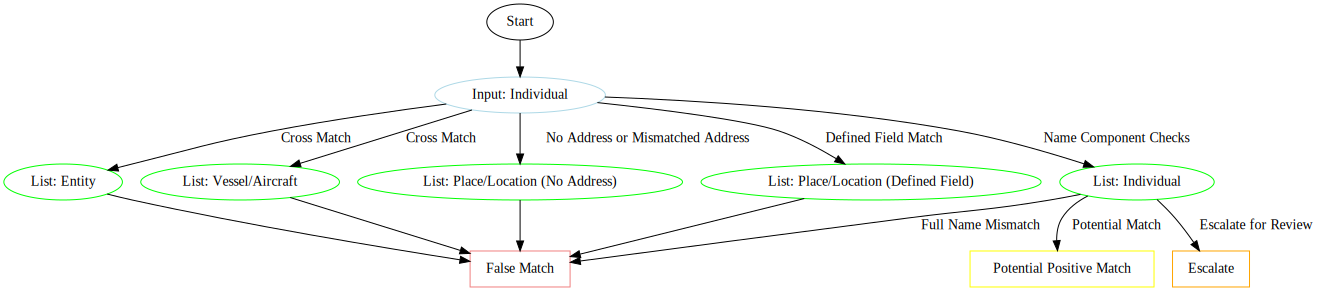

In [82]:
dot

In [83]:
dot.render('sanction_screening_individual_flowchart', view=False)


'sanction_screening_individual_flowchart.png'

## Add nuanced details: 

In [84]:
from graphviz import Digraph

dot = Digraph(comment='Sanction Screening Flow - Input: Individual', format='png')

# Define Nodes
dot.node('START', 'Start', shape='ellipse')
dot.node('CHECKLIST', 'Check Final List Type', shape='diamond')
dot.node('LENT', 'List: Entity', color='lightgreen', shape='box')
dot.node('LVESSEL', 'List: Vessel/Aircraft', color='lightgreen', shape='box')
dot.node('LPLACE', 'List: Place/Location', color='lightgreen', shape='box')
dot.node('LINDIVIDUAL', 'List: Individual', color='lightgreen', shape='box')

# Nodes for Address & Name Checks
dot.node('HAS_ADDRESS', 'Has Address?', shape='diamond', color='lightblue')
dot.node('HAS_NAME', 'Has Name Tag?', shape='diamond', color='lightblue')

# Nodes for Match Types & Rules
dot.node('FALSEMATCH1', 'False Match\nCross Match between Input (Individual) and List (Entity)', shape='box', color='lightcoral')
dot.node('FALSEMATCH2', 'False Match\nCross Match between Input (Individual) and List (Vessel/Aircraft)', shape='box', color='lightcoral')
dot.node('FALSEMATCH3', 'False Match\nName in field with additional identifiers, not an exact match to sanctioned location', shape='box', color='lightcoral')
dot.node('FALSEMATCH4', 'False Match\nName in a defined individual field and list entry is a place/location', shape='box', color='lightcoral')
dot.node('FALSEMATCH5', 'False Match\nSingle name component & list entry is multi name component', shape='box', color='lightcoral')
dot.node('FALSEMATCH6', 'False Match\nInput name has additional components not matching list entry', shape='box', color='lightcoral')
dot.node('FALSEMATCH7', 'False Match\nFull name mismatch', shape='box', color='lightcoral')
dot.node('POTENTIALMATCH', 'Potential Positive Match', shape='box', color='yellow')

# Define Edges
dot.edge('START', 'CHECKLIST')
dot.edge('CHECKLIST', 'LENT', label='Entity')
dot.edge('CHECKLIST', 'LVESSEL', label='Vessel/Aircraft')
dot.edge('CHECKLIST', 'LPLACE', label='Place/Location')
dot.edge('CHECKLIST', 'LINDIVIDUAL', label='Individual')

# Outcomes for Entity & Vessel/Aircraft
dot.edge('LENT', 'FALSEMATCH1')
dot.edge('LVESSEL', 'FALSEMATCH2')

# Outcomes for Place/Location
dot.edge('LPLACE', 'HAS_ADDRESS', label='Branch')
dot.edge('HAS_ADDRESS', 'FALSEMATCH3', label='No')
dot.edge('HAS_ADDRESS', 'HAS_NAME', label='Yes')
dot.edge('HAS_NAME', 'FALSEMATCH4', label='Yes')

# Outcomes for Individual
dot.edge('LINDIVIDUAL', 'FALSEMATCH5', label='Single Name Component')
dot.edge('LINDIVIDUAL', 'FALSEMATCH6', label='Extra Name Components')
dot.edge('LINDIVIDUAL', 'FALSEMATCH7', label='Name Mismatch')
dot.edge('LINDIVIDUAL', 'POTENTIALMATCH', label='Potential Match')

dot.render('sanction_screening_individual_flowchart_updated', view=False)


'sanction_screening_individual_flowchart_updated.png'

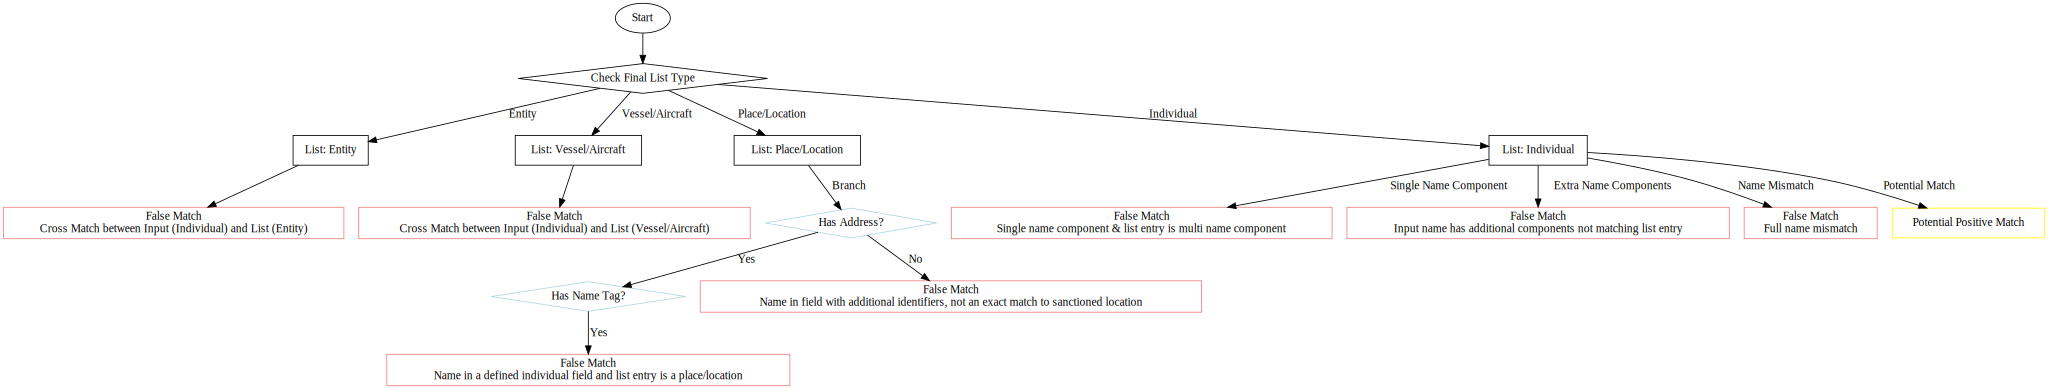

In [85]:
dot

In [89]:
from graphviz import Digraph

dot = Digraph(comment='Sanction Screening Flow - Input: Entity', format='png')

# Define Nodes
dot.node('START', 'Start\n(Input Type: Entity)', shape='ellipse', color='blue')
dot.node('CHECKLIST', 'Check Final List Type', shape='diamond')

dot.node('LPLACE', 'List: Place/Location', color='green', shape='box')
dot.node('LVESSEL', 'List: Vessel/Aircraft', color='green', shape='box')
dot.node('LENT', 'List: Entity', color='green', shape='box')
dot.node('LINDIVIDUAL', 'List: Individual', color='green', shape='box')

# Nodes for Entity Specific Guidelines
dot.node('MATCHDIFF', 'False Match\nMatching components are different', shape='box', color='lightcoral')
dot.node('COMMONREF', 'False Match\nCommon references but additional material name components', shape='box', color='lightcoral')
dot.node('FINNONMATCHBIC', 'False Match\nFinancial institutions with non-matching BIC', shape='box', color='lightcoral')
dot.node('NONFINMATCHBIC', 'False Match\nNon-financial institution matching against financial institution BIC', shape='box', color='lightcoral')

# Nodes for Individual Specific Guidelines
dot.node('NONEXUS', 'False Match\nNo nexus or connection between entity and individual', shape='box', color='lightcoral')

# Nodes for Escalation & False Matches
dot.node('ESCALATE_PLACE', 'Escalate\nPlace/Location requires escalation', shape='box', color='yellow')
dot.node('FALSEMATCH_VESSEL', 'False Match\nCross Match between Input (Entity) and List (Vessel/Aircraft)', shape='box', color='lightcoral')
dot.node('ESCALATE_ENTITY', 'Escalate\nPotential match for Entity', shape='box', color='yellow')
dot.node('ESCALATE_INDIVIDUAL', 'Escalate\nPotential match for Individual', shape='box', color='yellow')

# Define Edges
dot.edge('START', 'CHECKLIST')
dot.edge('CHECKLIST', 'LPLACE', label='Place/Location')
dot.edge('CHECKLIST', 'LVESSEL', label='Vessel/Aircraft')
dot.edge('CHECKLIST', 'LENT', label='Entity')
dot.edge('CHECKLIST', 'LINDIVIDUAL', label='Individual')

# Outcomes for Place/Location & Vessel/Aircraft
dot.edge('LPLACE', 'ESCALATE_PLACE')
dot.edge('LVESSEL', 'FALSEMATCH_VESSEL')

# Outcomes for Entity
dot.edge('LENT', 'MATCHDIFF', label='False Match\nMatching components different')
dot.edge('LENT', 'COMMONREF', label='False Match\nCommon references')
dot.edge('LENT', 'FINNONMATCHBIC', label='False Match\nFinancial institutions non-matching BIC')
dot.edge('LENT', 'NONFINMATCHBIC', label='False Match\nNon-financial vs financial BIC')
dot.edge('LENT', 'ESCALATE_ENTITY', label='Potential Match')

# Outcomes for Individual
dot.edge('LINDIVIDUAL', 'NONEXUS', label='No nexus/connection')
dot.edge('LINDIVIDUAL', 'ESCALATE_INDIVIDUAL', label='Potential Match')

# Render the graph
dot.render('sanction_screening_entity_flowchart')


'sanction_screening_entity_flowchart.png'

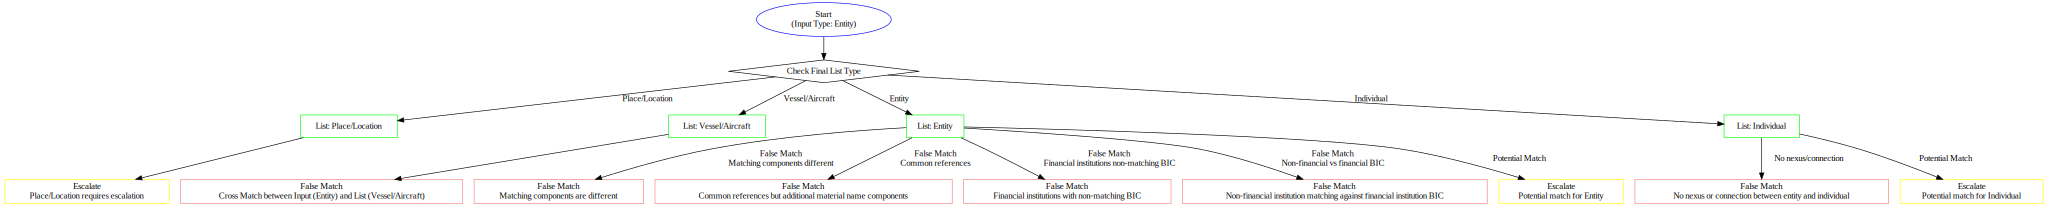

In [90]:
dot

In [93]:
from graphviz import Digraph

dot = Digraph(comment='Sanction Screening Flow - Input: Place/Location', format='png')

# Define Nodes
dot.node('START', 'Start\nInput Type: Place/Location', shape='ellipse', color='blue')
dot.node('CHECKLIST', 'Check Final List Type', shape='diamond')

dot.node('LPLACE', 'List: Place/Location', color='green', shape='box')
dot.node('LVESSEL', 'List: Vessel/Aircraft', color='green', shape='box')
dot.node('LENT', 'List: Entity', color='green', shape='box')
dot.node('LINDIVIDUAL', 'List: Individual', color='green', shape='box')

# Nodes for Place/Location Specific Guidelines
dot.node('VALIDLOC', 'False Match\ninput address is a valid location that is not the same location as referenced in the list entry nor otherwise in a sanctioned jurisdiction', shape='box', color='lightcoral')

# Nodes for Cross Match scenarios
dot.node('CROSSMATCH_ENT', 'False Match\nCross Match between Input (Place/Location) and List (Entity)', shape='box', color='lightcoral')
dot.node('CROSSMATCH_IND', 'False Match\nCross Match between Input (Place/Location) and List (Individual)', shape='box', color='lightcoral')
dot.node('CROSSMATCH_VES', 'False Match\nCross Match between Input (Place/Location) and List (Vessel/Aircraft)', shape='box', color='lightcoral')

# Nodes for Potential Positive Match
dot.node('POTMATCH', 'Potential Positive Match\nEscalated for further review', shape='box', color='yellow')

# Define Edges
dot.edge('START', 'CHECKLIST')
dot.edge('CHECKLIST', 'LPLACE', label='Place/Location')
dot.edge('CHECKLIST', 'LVESSEL', label='Vessel/Aircraft')
dot.edge('CHECKLIST', 'LENT', label='Entity')
dot.edge('CHECKLIST', 'LINDIVIDUAL', label='Individual')

# Outcomes for Place/Location
dot.edge('LPLACE', 'VALIDLOC', label='Valid location different from list entry')
dot.edge('LPLACE', 'POTMATCH', label='Potential Match')

# Cross Match Scenarios for Place/Location
dot.edge('LVESSEL', 'CROSSMATCH_VES')
dot.edge('LENT', 'CROSSMATCH_ENT')
dot.edge('LINDIVIDUAL', 'CROSSMATCH_IND')

# Render the graph
dot.render('sanction_screening_place_location_flowchart')


'sanction_screening_place_location_flowchart.png'

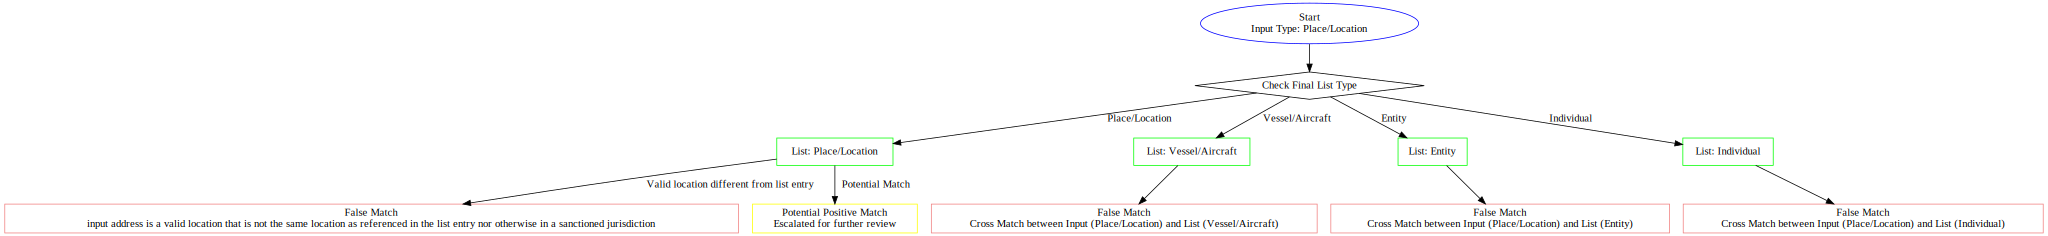

In [94]:
dot

In [97]:
from graphviz import Digraph

dot = Digraph(comment='Sanction Screening Flow - Input: Vessel/Aircraft', format='png')

# Define Nodes
dot.node('START', 'Start\nInput Type: Vessel/Aircraft', shape='ellipse', color='blue')
dot.node('CHECKLIST', 'Check Final List Type', shape='diamond')

dot.node('LPLACE', 'List: Place/Location', color='green', shape='box')
dot.node('LVESSEL', 'List: Vessel/Aircraft', color='green', shape='box')
dot.node('LENT', 'List: Entity', color='green', shape='box')
dot.node('LINDIVIDUAL', 'List: Individual', color='green', shape='box')

# Nodes for Vessel/Aircraft Specific Guidelines
dot.node('FALSEMATCH_INDIVIDUAL', 'False Match\nCross Match between Input (Vessel/Aircraft) and List (Individual)', shape='box', color='lightcoral')
dot.node('ESCALATE_PLACE', 'Escalate\nPotential Positive Match', shape='box', color='yellow')
dot.node('PHASE2_ENTITY', 'Phase 2: Review Needed for Entity', shape='box', color='orange')
dot.node('PHASE2_VESSEL', 'Phase 2: Review Needed for Vessel/Aircraft', shape='box', color='orange')

# Define Edges
dot.edge('START', 'CHECKLIST')
dot.edge('CHECKLIST', 'LPLACE', label='Place/Location')
dot.edge('CHECKLIST', 'LVESSEL', label='Vessel/Aircraft (Phase 2)')
dot.edge('CHECKLIST', 'LENT', label='Entity (Phase 2)')
dot.edge('CHECKLIST', 'LINDIVIDUAL', label='Individual')

# Outcomes for Vessel/Aircraft
dot.edge('LPLACE', 'ESCALATE_PLACE')
dot.edge('LVESSEL', 'PHASE2_VESSEL')
dot.edge('LENT', 'PHASE2_ENTITY')
dot.edge('LINDIVIDUAL', 'FALSEMATCH_INDIVIDUAL')

# Render the graph
dot.render('sanction_screening_vessel_aircraft_flowchart')

'sanction_screening_vessel_aircraft_flowchart.png'

In [99]:
from graphviz import Digraph

dot = Digraph(comment='Sanction Screening Flow - Input: Other Input Type', format='png')

# Define Nodes
dot.node('START', 'Start\nInput Type: Other', shape='ellipse', color='blue')
dot.node('CHECKLIST', 'Check Final List Type', shape='diamond')

dot.node('LPLACE', 'List: Place/Location', color='green', shape='box')
dot.node('LVESSEL', 'List: Vessel/Aircraft', color='green', shape='box')
dot.node('LENT', 'List: Entity', color='green', shape='box')
dot.node('LINDIVIDUAL', 'List: Individual', color='green', shape='box')

# Nodes for Specific False Match Scenarios
dot.node('CURRENCY', 'False Match\nCurrency Reference', shape='box', color='lightcoral')
dot.node('DATE', 'False Match\nDate Reference', shape='box', color='lightcoral')
dot.node('PARTIALACC', 'False Match\nPartial Account Number', shape='box', color='lightcoral')
dot.node('ALPHANUM', 'False Match\nAlphanumeric Reference', shape='box', color='lightcoral')
dot.node('KNOWNINPUT', 'False Match\nKnown Input Type', shape='box', color='lightcoral')
dot.node('SANCTIONINV', 'False Match\nSanctions Investigation', shape='box', color='lightcoral')

# Node for Escalation
dot.node('ESCALATE', 'Escalate\nPotential Positive Match scenario', shape='box', color='yellow')

# Node for Review
dot.node('REVIEW', 'Review Needed\nNo conditions met', shape='box', color='lightyellow')

# Define Edges
dot.edge('START', 'CHECKLIST')
dot.edge('CHECKLIST', 'LPLACE')
dot.edge('CHECKLIST', 'LVESSEL')
dot.edge('CHECKLIST', 'LENT')
dot.edge('CHECKLIST', 'LINDIVIDUAL')

# Outcomes for Specific False Match Scenarios
dot.edge('LPLACE', 'CURRENCY')
dot.edge('LPLACE', 'DATE')
dot.edge('LPLACE', 'PARTIALACC')
dot.edge('LPLACE', 'ALPHANUM')
dot.edge('LPLACE', 'KNOWNINPUT')
dot.edge('LPLACE', 'SANCTIONINV')

dot.edge('LVESSEL', 'CURRENCY')
dot.edge('LVESSEL', 'DATE')
dot.edge('LVESSEL', 'PARTIALACC')
dot.edge('LVESSEL', 'ALPHANUM')
dot.edge('LVESSEL', 'KNOWNINPUT')
dot.edge('LVESSEL', 'SANCTIONINV')

dot.edge('LENT', 'CURRENCY')
dot.edge('LENT', 'DATE')
dot.edge('LENT', 'PARTIALACC')
dot.edge('LENT', 'ALPHANUM')
dot.edge('LENT', 'KNOWNINPUT')
dot.edge('LENT', 'SANCTIONINV')

dot.edge('LINDIVIDUAL', 'CURRENCY')
dot.edge('LINDIVIDUAL', 'DATE')
dot.edge('LINDIVIDUAL', 'PARTIALACC')
dot.edge('LINDIVIDUAL', 'ALPHANUM')
dot.edge('LINDIVIDUAL', 'KNOWNINPUT')
dot.edge('LINDIVIDUAL', 'SANCTIONINV')

# Outcomes for Escalation
dot.edge('LPLACE', 'ESCALATE')
dot.edge('LVESSEL', 'ESCALATE')
dot.edge('LENT', 'ESCALATE')
dot.edge('LINDIVIDUAL', 'ESCALATE')

# Outcomes for Review Needed
dot.edge('LPLACE', 'REVIEW')
dot.edge('LVESSEL', 'REVIEW')
dot.edge('LENT', 'REVIEW')
dot.edge('LINDIVIDUAL', 'REVIEW')

# Render the graph
dot.render('sanction_screening_other_input_type_flowchart')


'sanction_screening_other_input_type_flowchart.png'